In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd
import os
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## 1. Data Loading

In [42]:
# sampling frequency from paper
fs = 100
ninapro_root = "./Ninapro/DB1"
print(os.path.abspath(ninapro_root))

all_emg = {}
all_data = {}
for filename in os.listdir(ninapro_root):
    if filename.endswith("A1_E1.mat"):
        full_path = os.path.join(ninapro_root, filename)

        subject_id = filename.split("_")[0]  # "S1", "S2", ...

        mat = loadmat(full_path)
        emg = mat["emg"]
        all_data[subject_id] = mat
        all_emg[subject_id] = emg

print(all_emg.keys())
print(all_data['S1'].keys()) 
# dictionary with all subject emgs

/Users/oppizz/Documents/Neuro/projNSSP2/NSSP_project2_groupK/Ninapro/DB1
dict_keys(['S22', 'S8', 'S17', 'S5', 'S11', 'S24', 'S3', 'S9', 'S23', 'S16', 'S4', 'S10', 'S25', 'S2', 'S15', 'S20', 'S18', 'S7', 'S26', 'S13', 'S1', 'S14', 'S21', 'S19', 'S6', 'S27', 'S12'])
dict_keys(['__header__', '__version__', '__globals__', 'emg', 'stimulus', 'glove', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'])
dict_keys(['S22', 'S8', 'S17', 'S5', 'S11', 'S24', 'S3', 'S9', 'S23', 'S16', 'S4', 'S10', 'S25', 'S2', 'S15', 'S20', 'S18', 'S7', 'S26', 'S13', 'S1', 'S14', 'S21', 'S19', 'S6', 'S27', 'S12'])
dict_keys(['__header__', '__version__', '__globals__', 'emg', 'stimulus', 'glove', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'])


# 2. Visualization and Preprocessing

## 2.1. Visualize signals

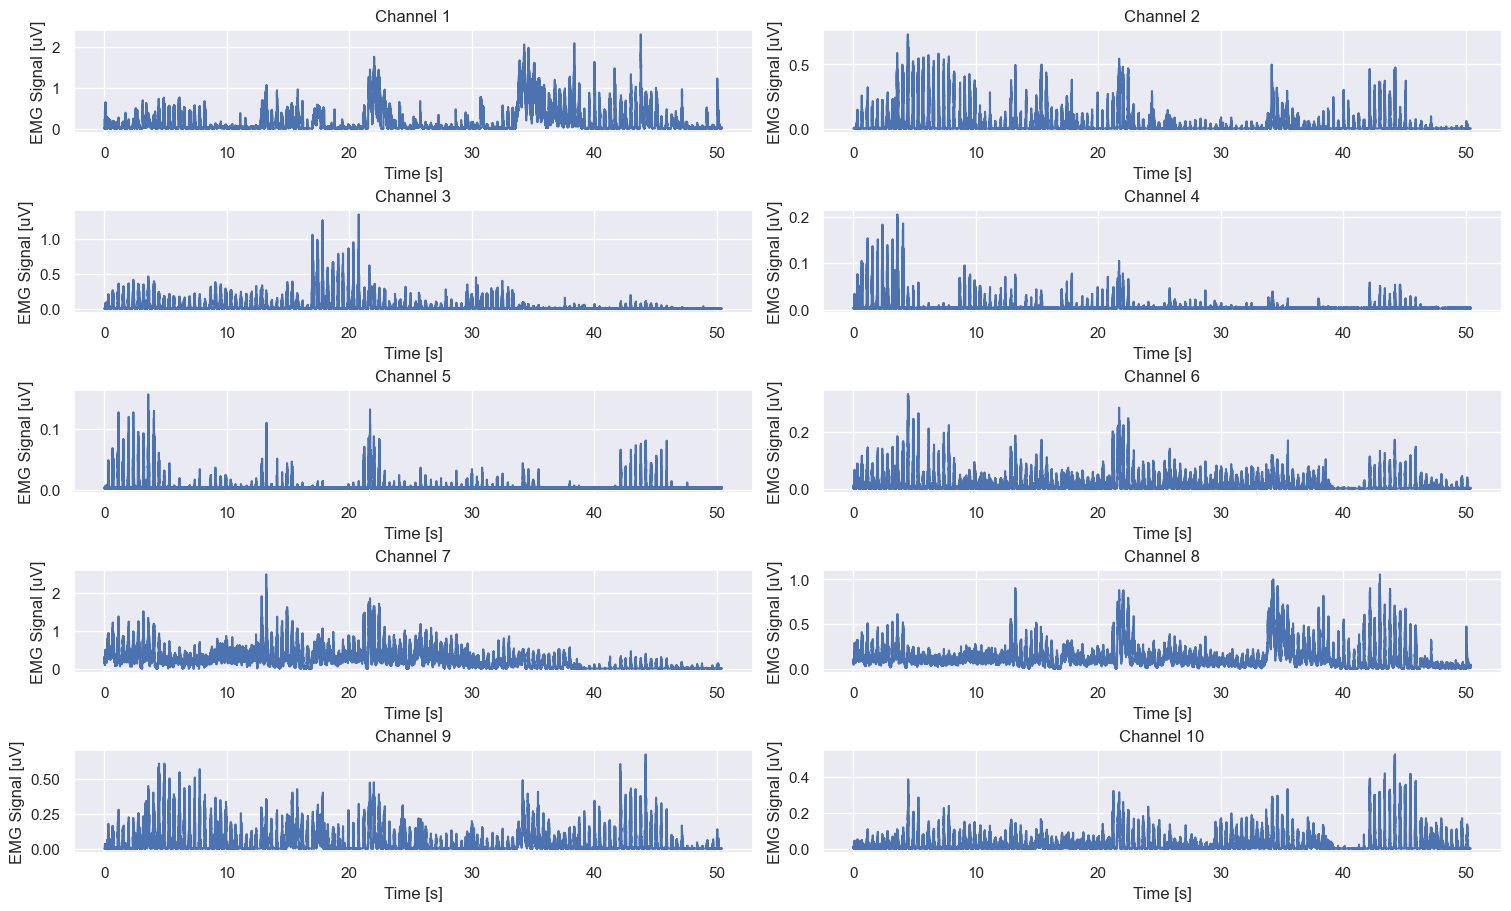

In [43]:
# Plot all channels time series for subject S4 (could be any subject)

emg = all_emg['S4']
n_channels = emg.shape[1]
time_steps = np.arange(0, emg.shape[0]/fs, 1/fs)

fig, ax = plt.subplots(5, 2, constrained_layout=True, figsize=(15, 9))
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg[:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")
fig.savefig("plots/emg_channels_timeseries.png", dpi=300, bbox_inches="tight")
plt.show()

In [44]:
# Process and extract relevant variables for all subjects

all_processed = {}

for subject in all_data.keys():

    data = all_data[subject]

    # Extract variables for this subject
    emg_rectified = data["emg"].copy()
    stimulus = data["restimulus"].squeeze()
    repetition = data["rerepetition"].squeeze()

    # Store them
    all_processed[subject] = {
        "emg": emg_rectified,
        "stimulus": stimulus,
        "repetition": repetition
    }

    # Print basic info for this subject
    print(f"Subject: {subject}")
    print(f"  EMG shape:        {emg_rectified.shape}")
    print(f"  Stimulus shape:   {stimulus.shape}")
    print(f"  Repetition shape: {repetition.shape}")
    print("-" * 40)

Subject: S22
  EMG shape:        (101884, 10)
  Stimulus shape:   (101884,)
  Repetition shape: (101884,)
----------------------------------------
Subject: S8
  EMG shape:        (100854, 10)
  Stimulus shape:   (100854,)
  Repetition shape: (100854,)
----------------------------------------
Subject: S17
  EMG shape:        (101675, 10)
  Stimulus shape:   (101675,)
  Repetition shape: (101675,)
----------------------------------------
Subject: S5
  EMG shape:        (100894, 10)
  Stimulus shape:   (100894,)
  Repetition shape: (100894,)
----------------------------------------
Subject: S11
  EMG shape:        (100899, 10)
  Stimulus shape:   (100899,)
  Repetition shape: (100899,)
----------------------------------------
Subject: S24
  EMG shape:        (101698, 10)
  Stimulus shape:   (101698,)
  Repetition shape: (101698,)
----------------------------------------
Subject: S3
  EMG shape:        (100720, 10)
  Stimulus shape:   (100720,)
  Repetition shape: (100720,)
---------------

## 2.1. Preprocessing for All Subjects

In [45]:
# Extract EMG windows and envelopes for all subjects

N_STIMULI = 12  
N_REPETITIONS = 10 

MOV_MEAN_LENGTH = 25
MOV_MEAN_WEIGHTS = np.ones(MOV_MEAN_LENGTH) / MOV_MEAN_LENGTH

for subject in all_processed.keys():
    
    data = all_processed[subject]
    emg_rectified = data["emg"]
    stimulus = data["stimulus"]
    repetition = data["repetition"]


    emg_windows = [[None for repetition_idx in range(N_REPETITIONS)] for stimuli_idx in range(N_STIMULI)]
    emg_envelopes = [[None for repetition_idx in range(N_REPETITIONS)] for stimuli_idx in range(N_STIMULI)]
    
    for stimuli_idx in range(N_STIMULI):
        for repetition_idx in range(N_REPETITIONS):
            current_stimulus = stimuli_idx + 1
            current_repetition = repetition_idx + 1
            
            idx = np.logical_and(stimulus == current_stimulus, repetition == current_repetition)
            
            window = emg_rectified[idx, :]
            
            if window.shape[0] > 0:
                emg_windows[stimuli_idx][repetition_idx] = window
                
                emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(
                    window, 
                    MOV_MEAN_WEIGHTS, 
                    axis=0
                )
    
    all_processed[subject]["emg_windows"] = emg_windows
    all_processed[subject]["emg_envelopes"] = emg_envelopes
    

print("Processing and extraction complete for all subjects.")

Processing and extraction complete for all subjects.


## 2.2. Single Trial Visualization

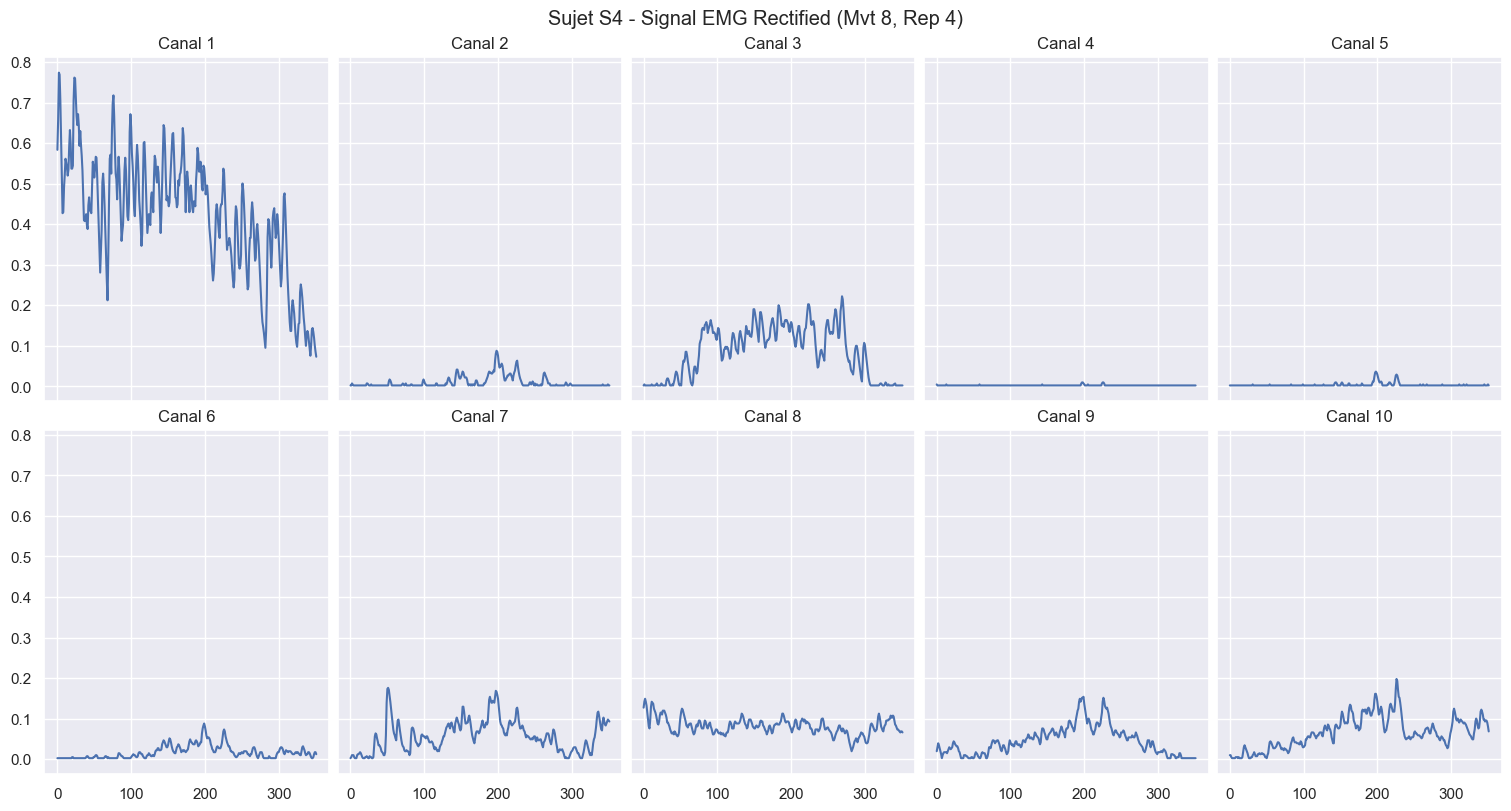

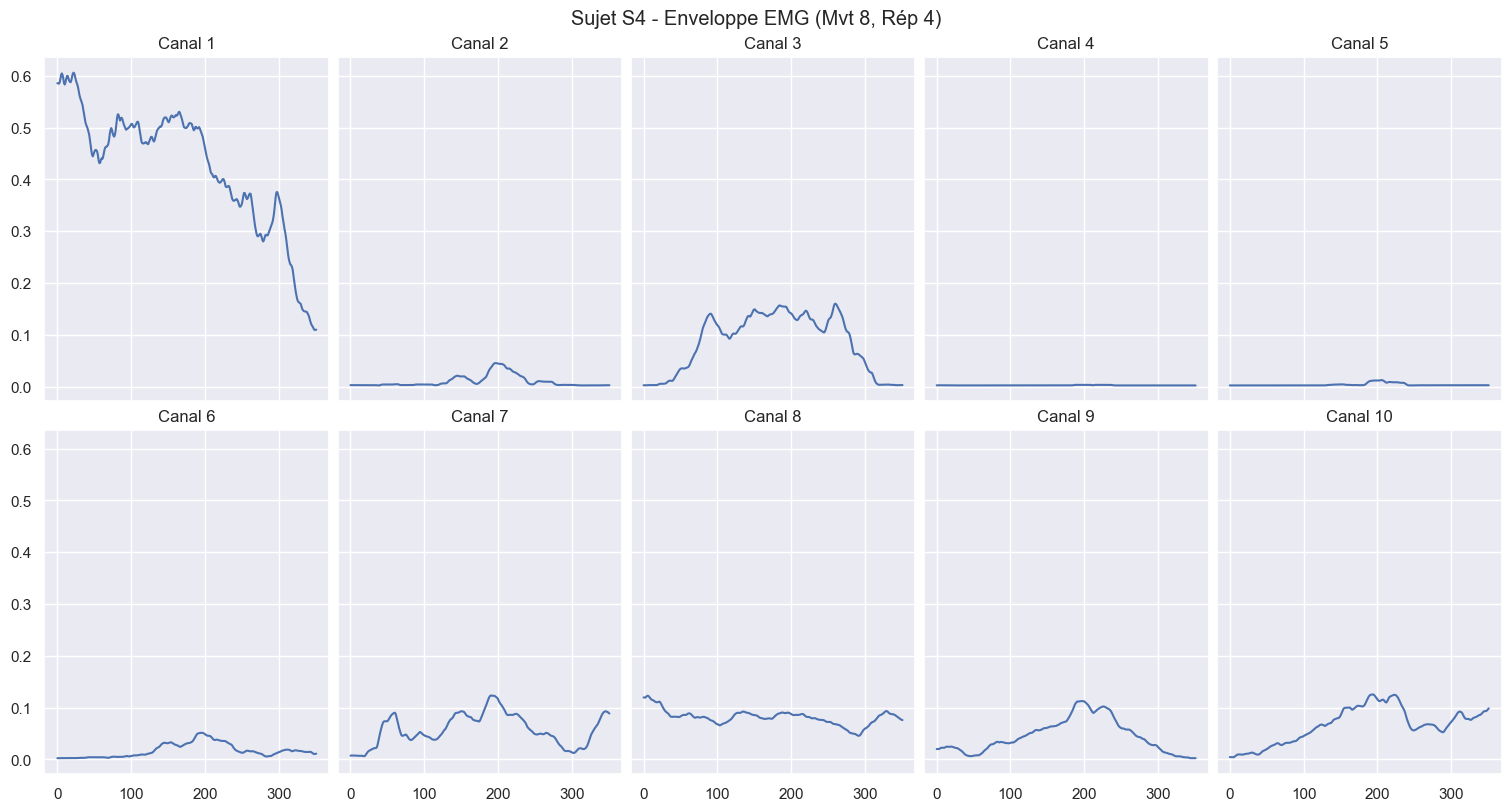

In [46]:
# Plot EMG windows and envelopes for a specific subject, stimulus, and repetition

SUBJECT_TO_PLOT = 'S4'
STIMULUS_INDEX_TO_PLOT = 7
REPETITION_INDEX_TO_PLOT = 3

if SUBJECT_TO_PLOT in all_processed:
    windows_data = all_processed[SUBJECT_TO_PLOT]["emg_windows"]
    envelopes_data = all_processed[SUBJECT_TO_PLOT]["emg_envelopes"]
    
    emg_window = windows_data[STIMULUS_INDEX_TO_PLOT][REPETITION_INDEX_TO_PLOT]
    emg_envelope = envelopes_data[STIMULUS_INDEX_TO_PLOT][REPETITION_INDEX_TO_PLOT]
    
    if emg_window is not None:
        number_of_emg_channels = emg_window.shape[1] 

        fig, ax = plt.subplots(2, 5, figsize=(15, 8), constrained_layout=True, sharex=True, sharey=True)
        ax = ax.ravel()
        for channel_idx in range(number_of_emg_channels): 
            ax[channel_idx].plot(emg_window[:, channel_idx])
            ax[channel_idx].set_title(f"Canal {channel_idx+1}")
        plt.suptitle(f"Sujet {SUBJECT_TO_PLOT} - Signal EMG Rectified (Mvt {STIMULUS_INDEX_TO_PLOT+1}, Rep {REPETITION_INDEX_TO_PLOT+1})")
        plt.show() 

        fig, ax = plt.subplots(2, 5, figsize=(15, 8), constrained_layout=True, sharex=True, sharey=True)
        ax = ax.ravel()
        for channel_idx in range(number_of_emg_channels): 
            ax[channel_idx].plot(emg_envelope[:, channel_idx])
            ax[channel_idx].set_title(f"Canal {channel_idx+1}")
        plt.suptitle(f"Sujet {SUBJECT_TO_PLOT} - Enveloppe EMG (Mvt {STIMULUS_INDEX_TO_PLOT+1}, Rép {REPETITION_INDEX_TO_PLOT+1})")
        plt.show()

## 2.3 Average EMG Activation (MAV) per Channel, Movement, and Repetition

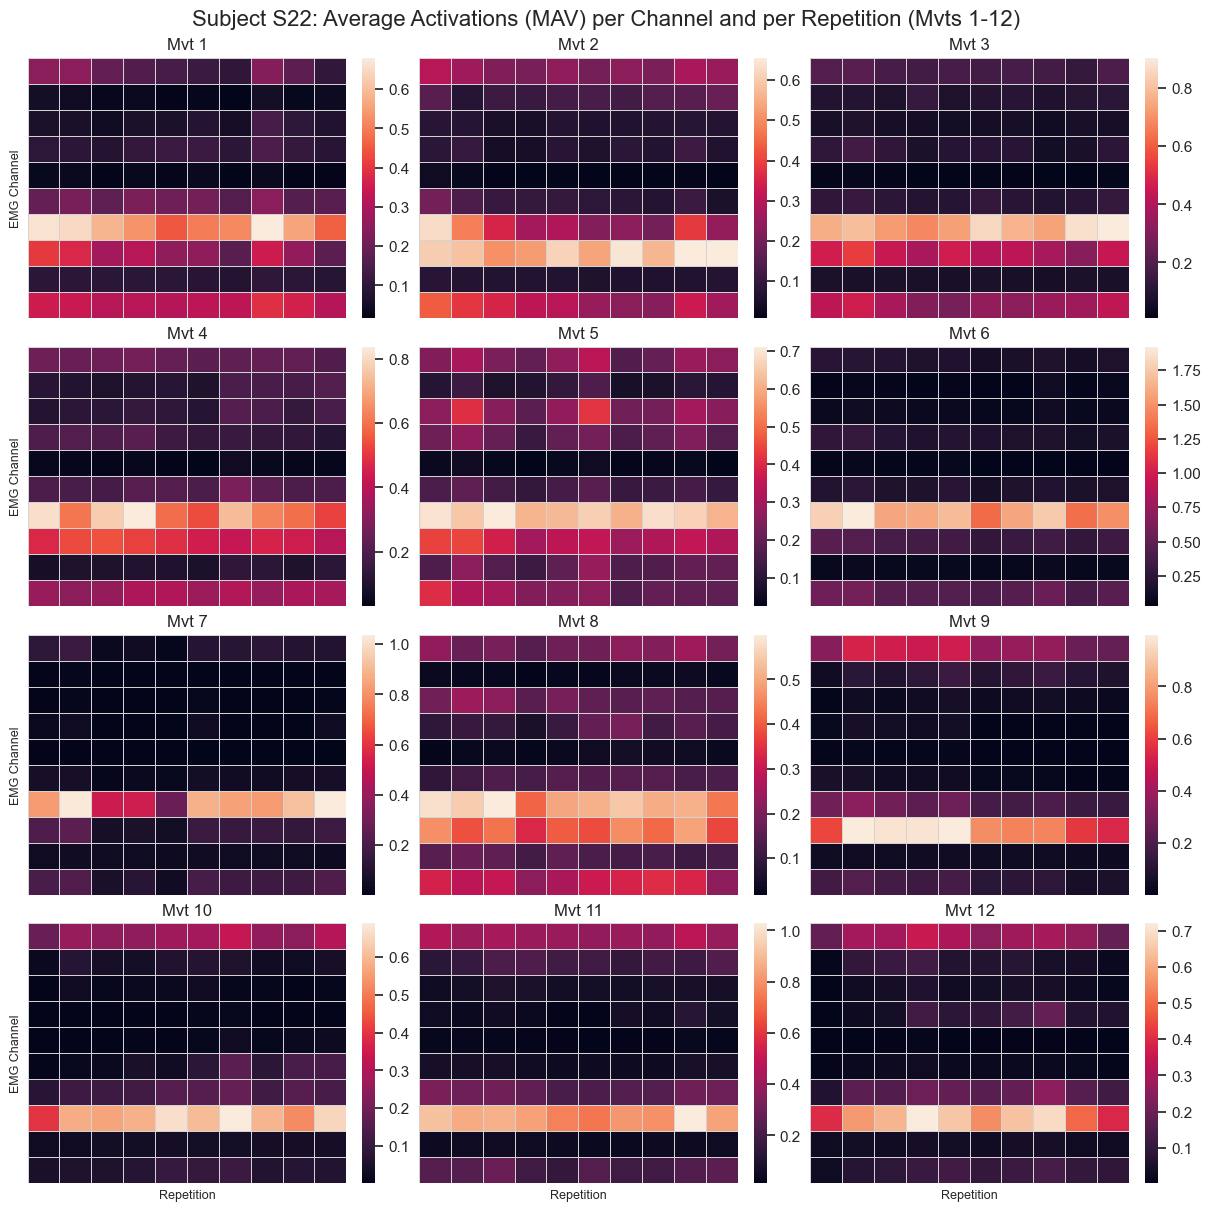

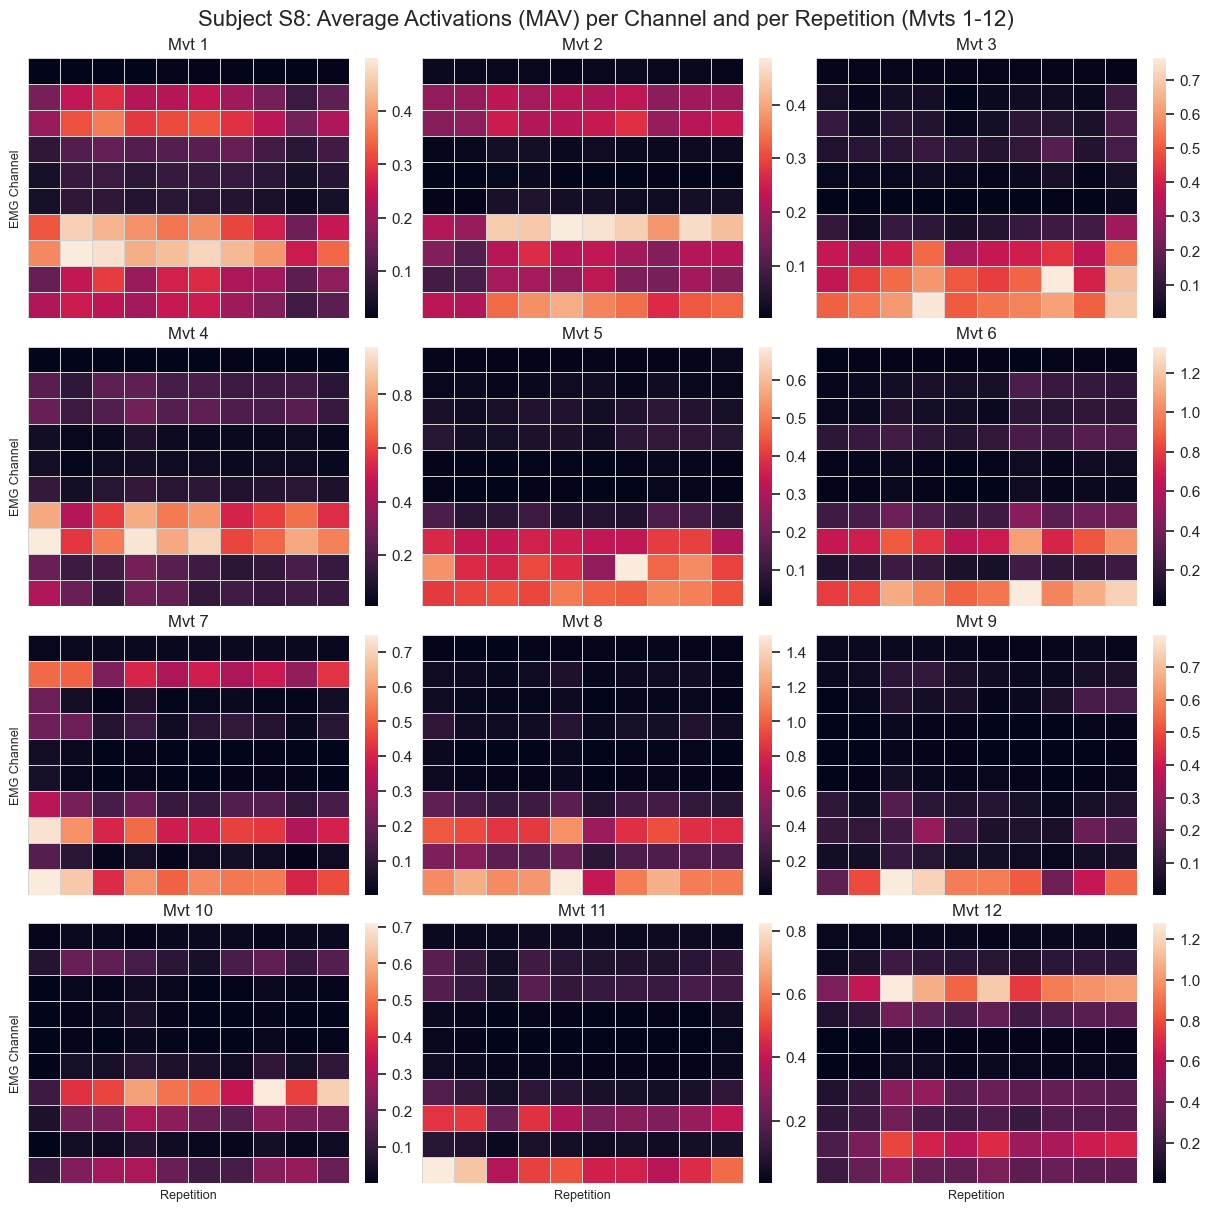

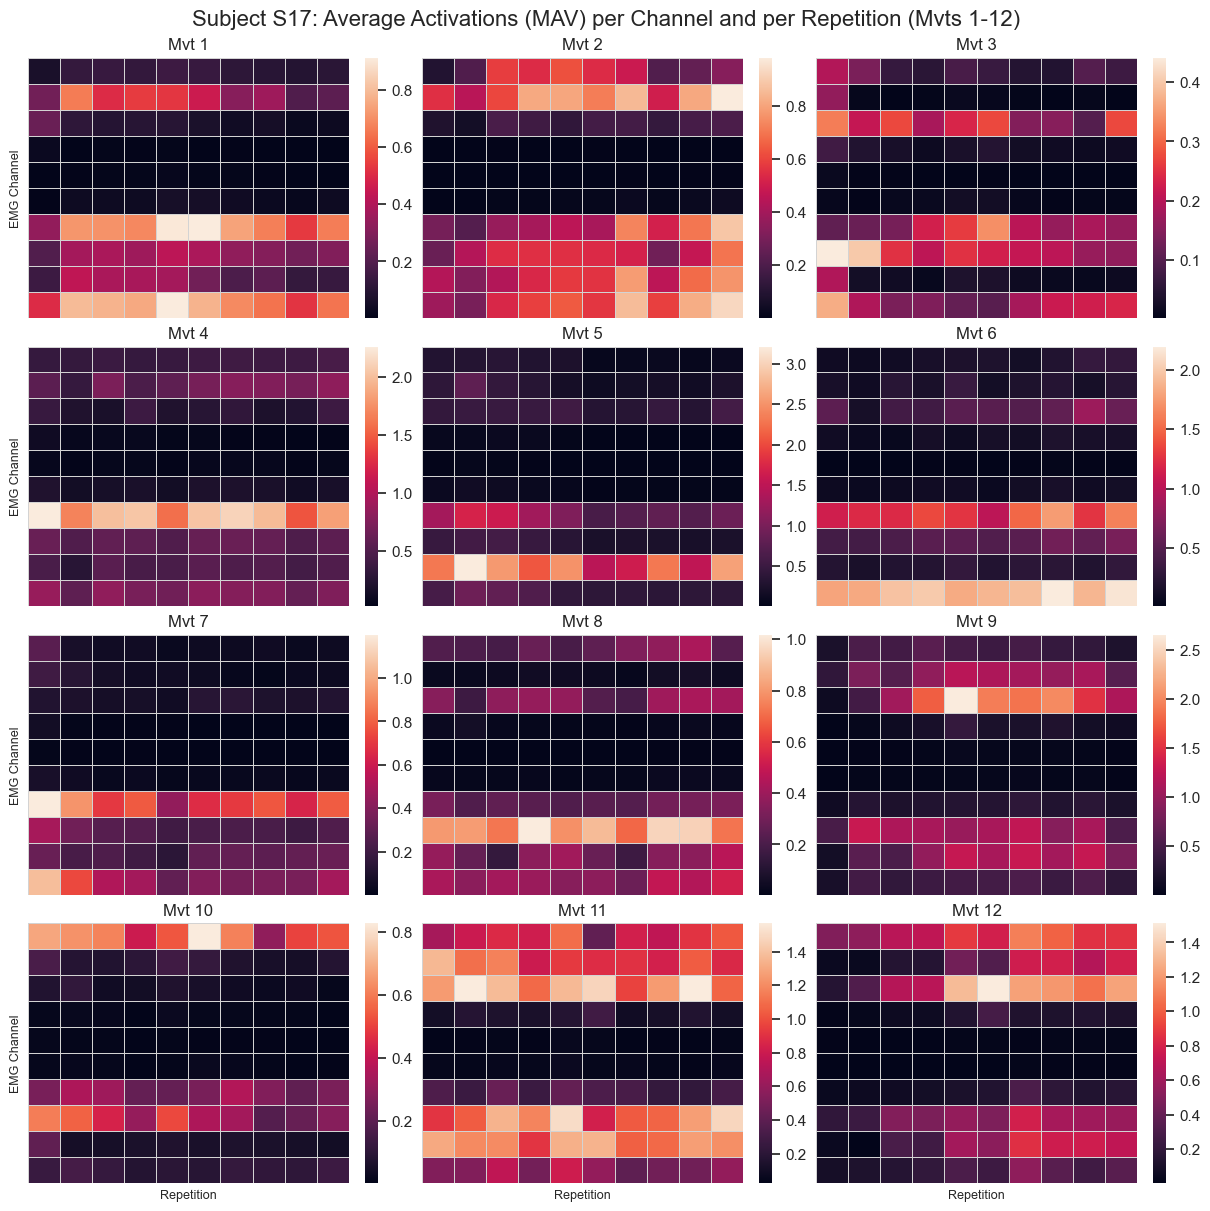

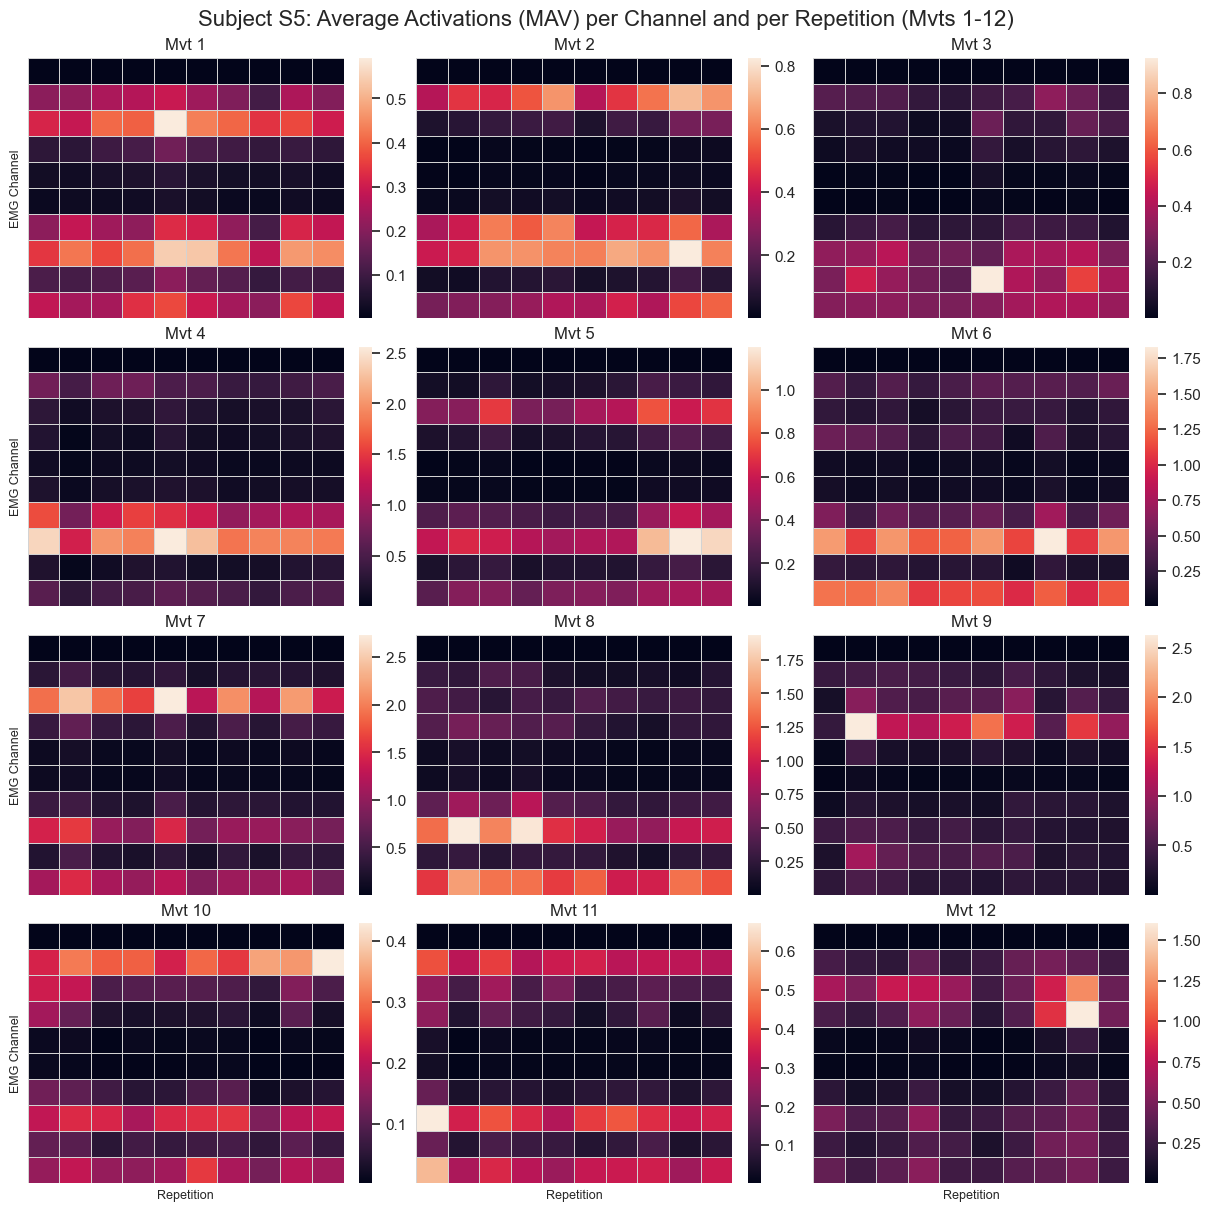

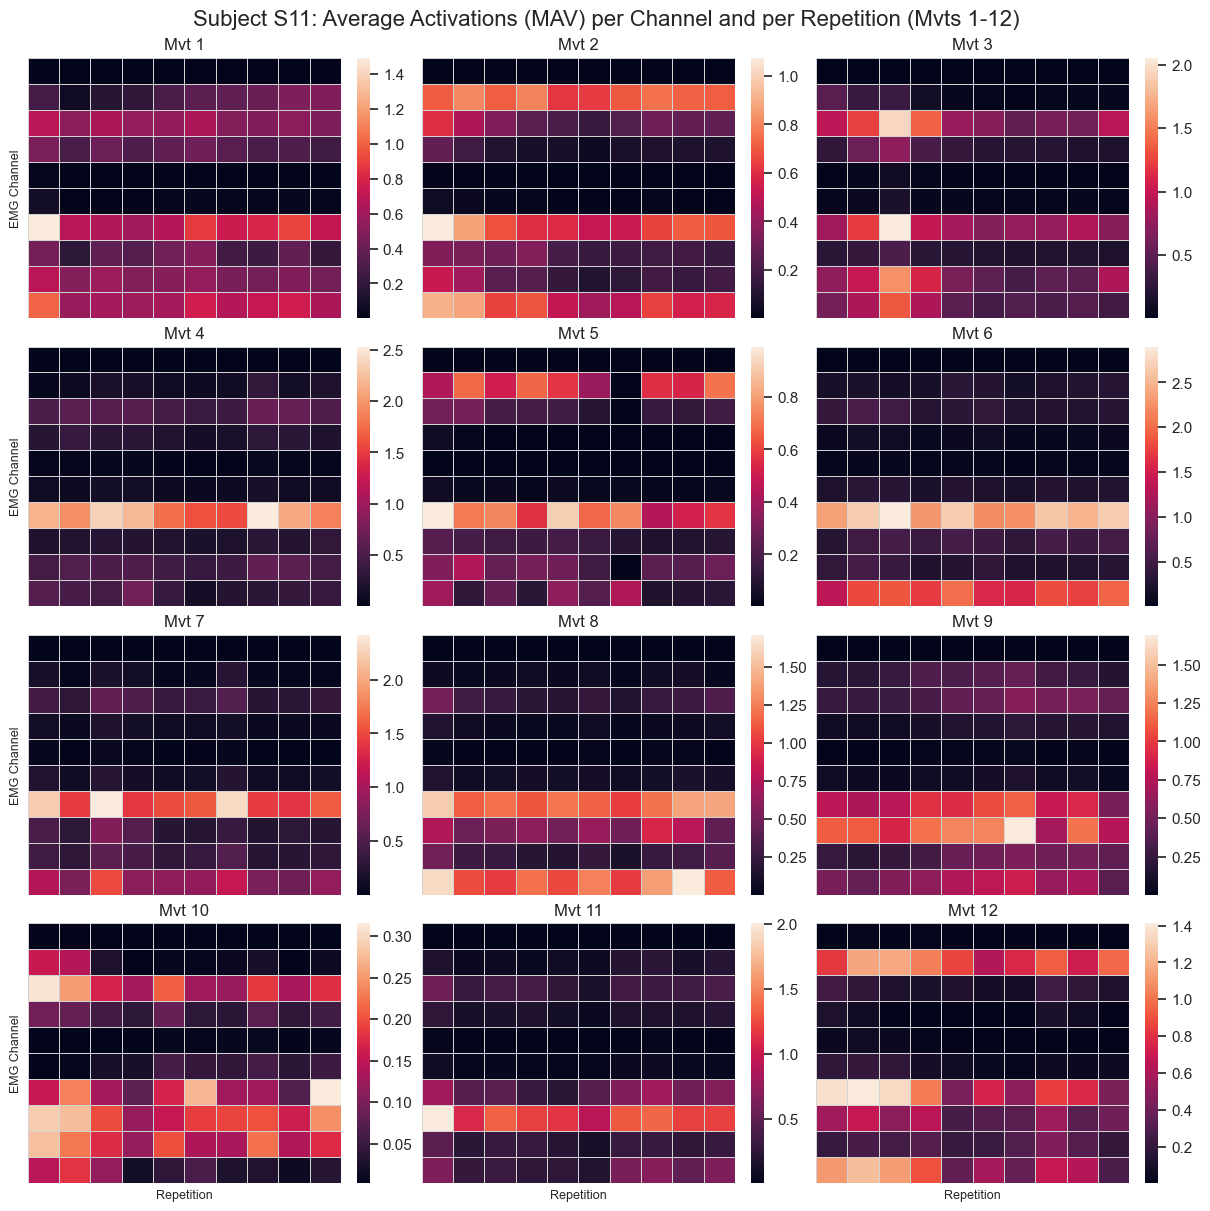

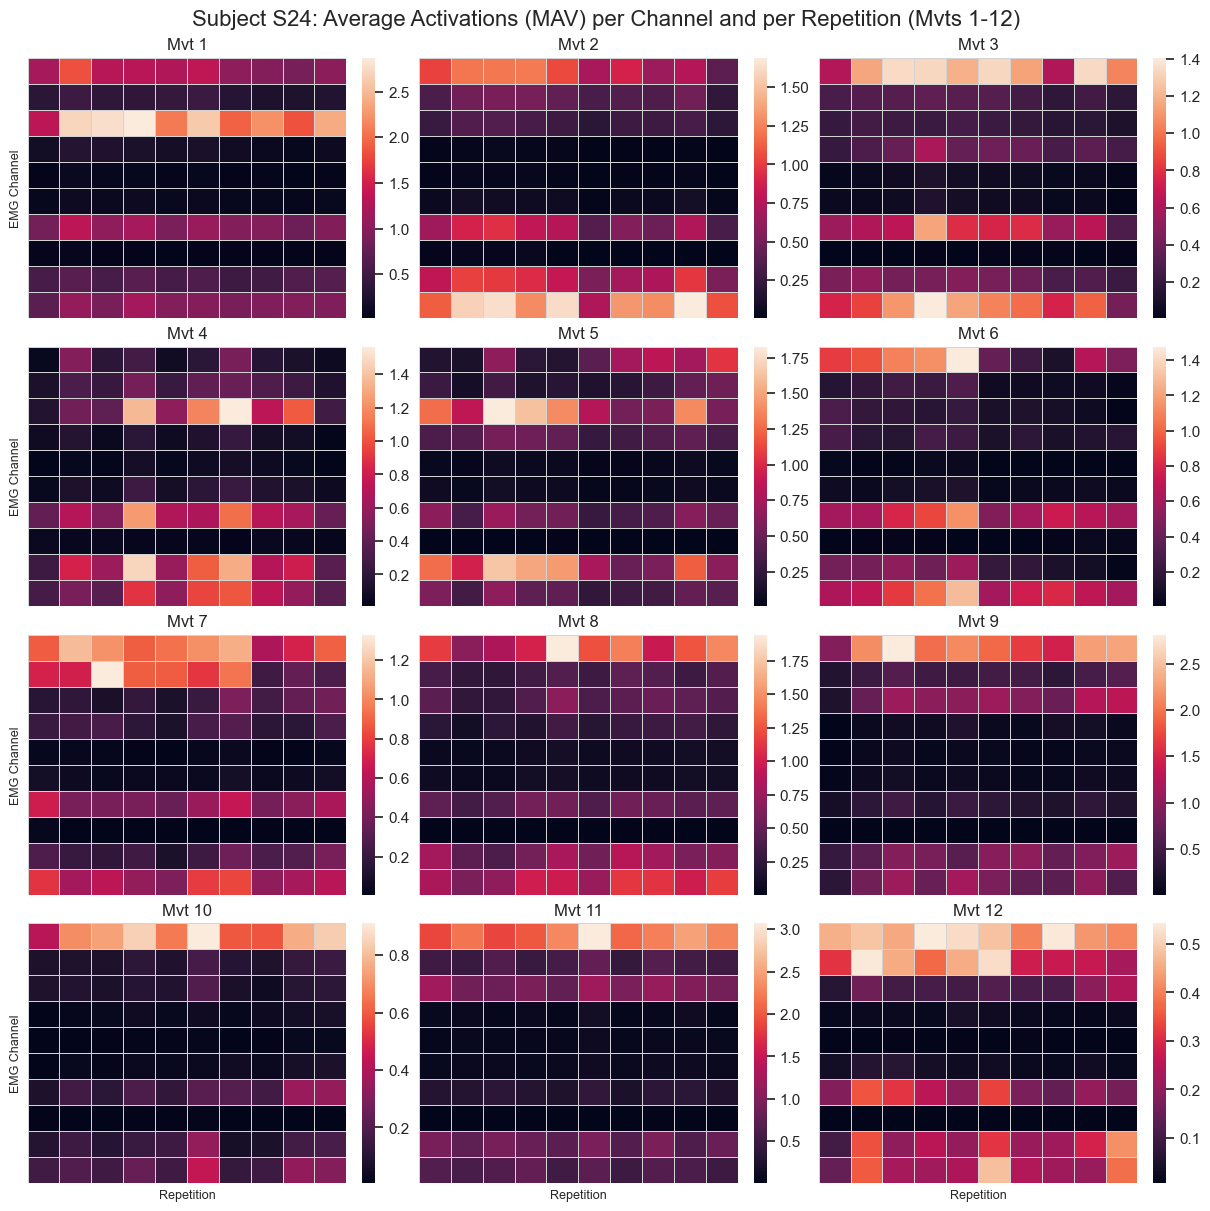

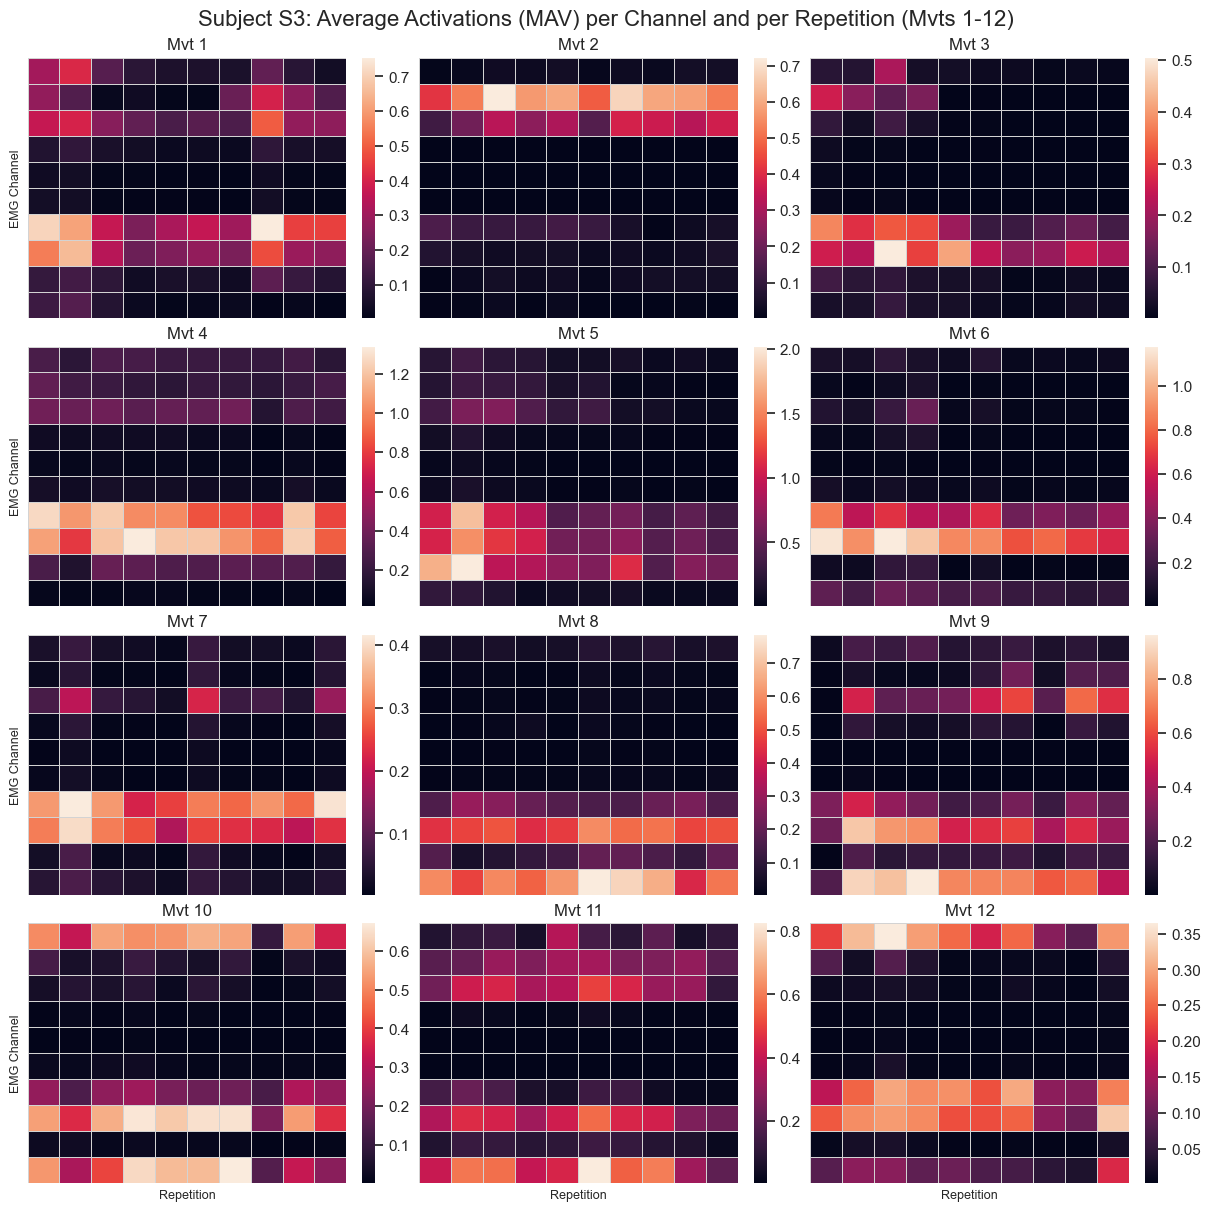

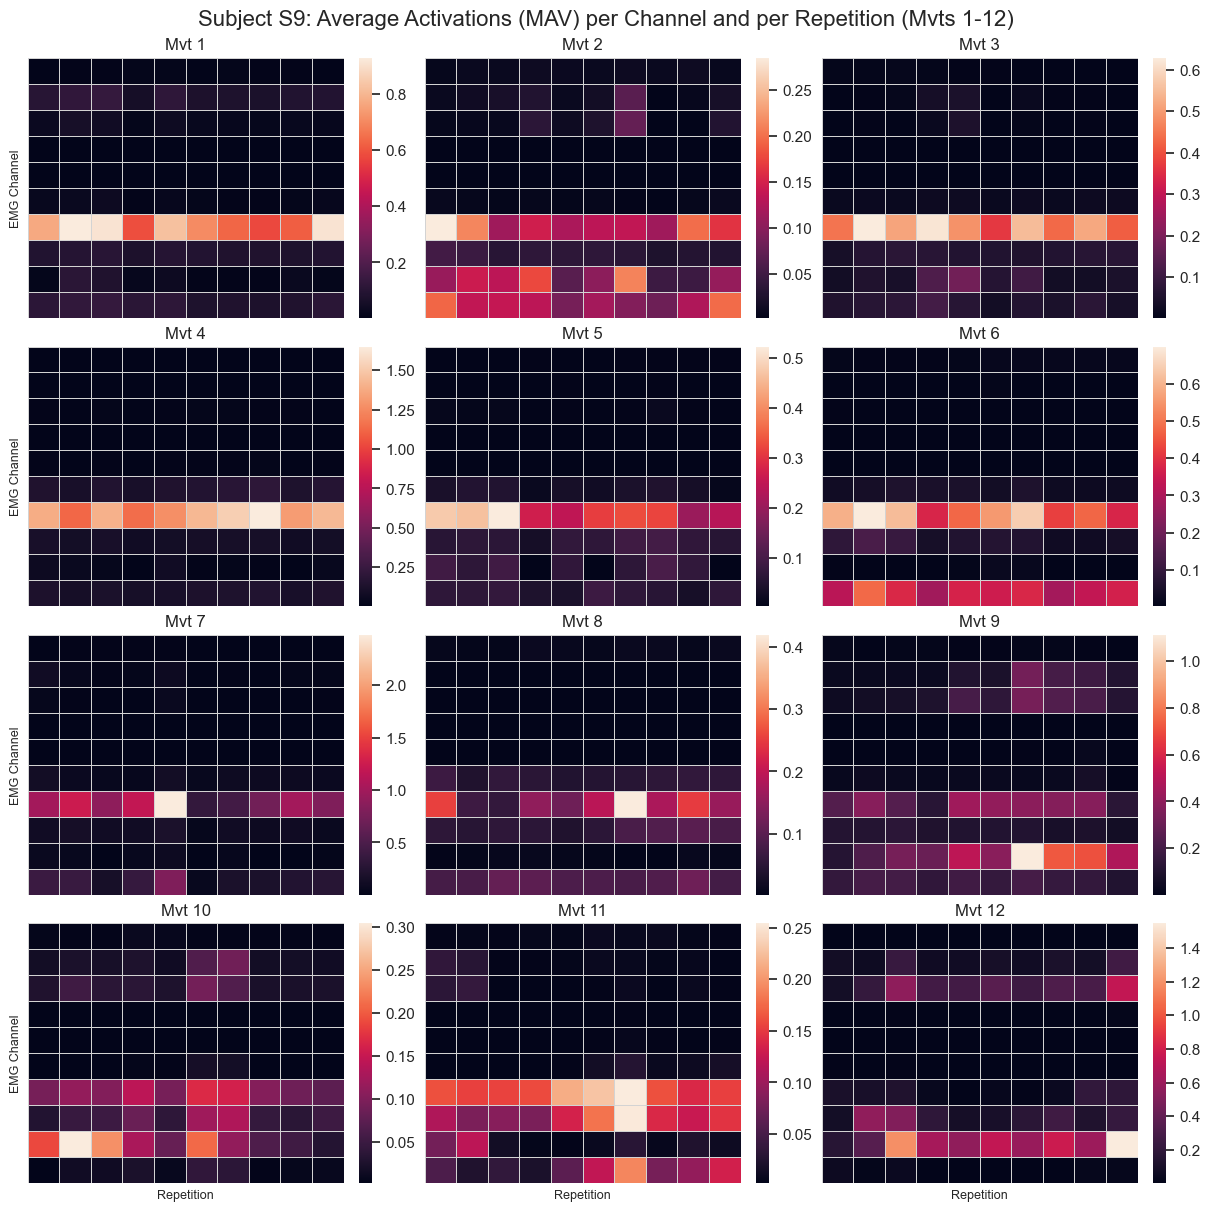

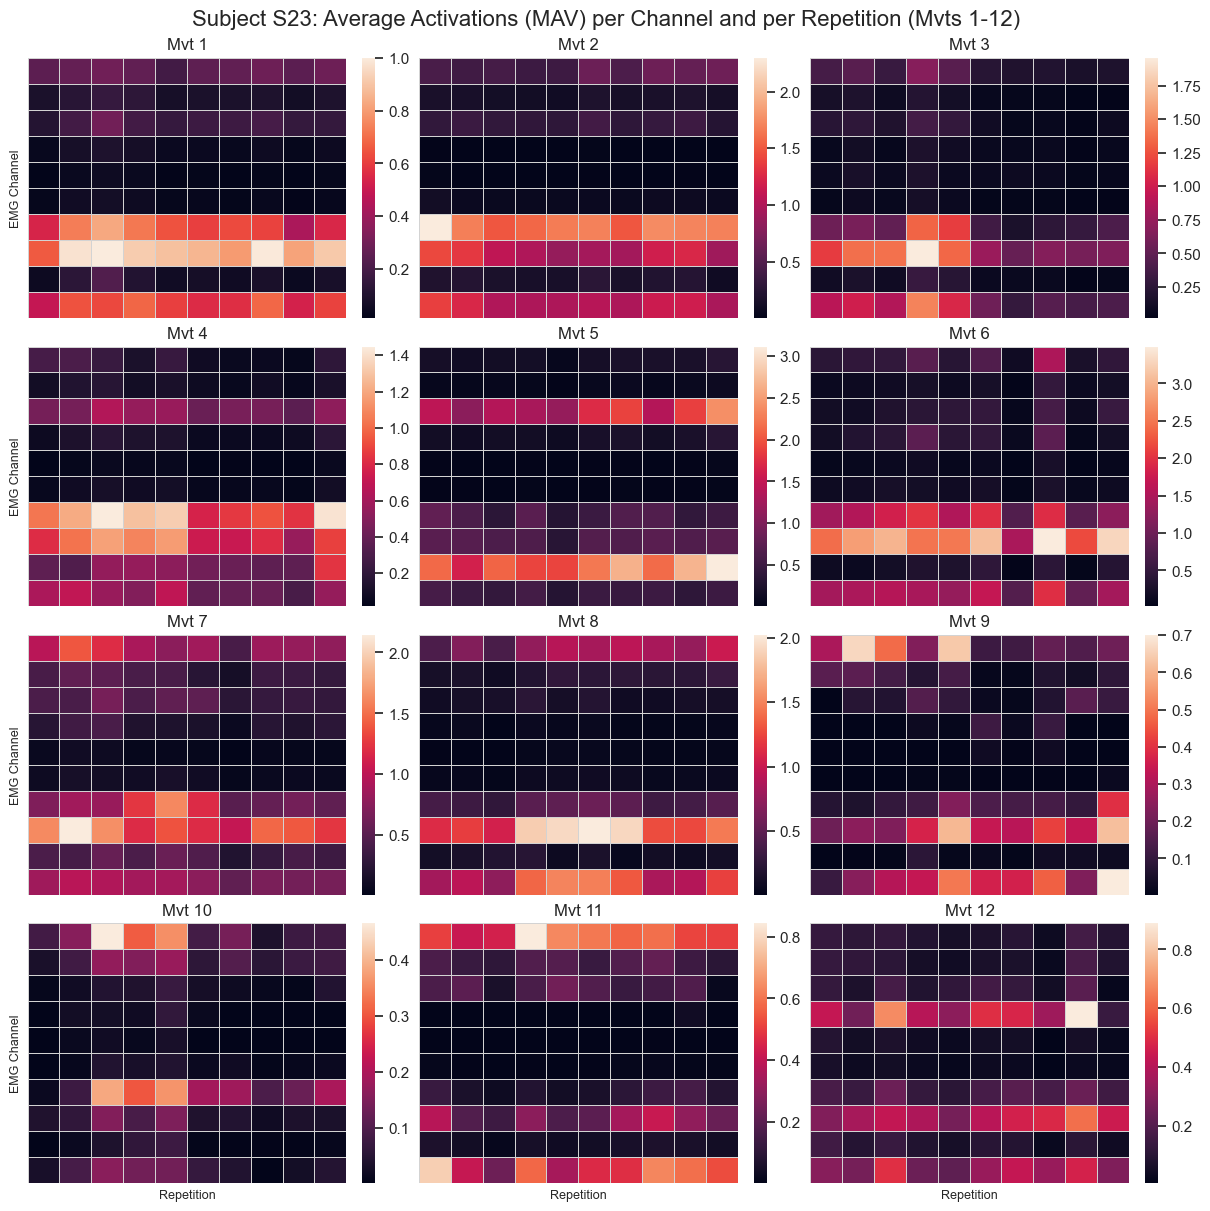

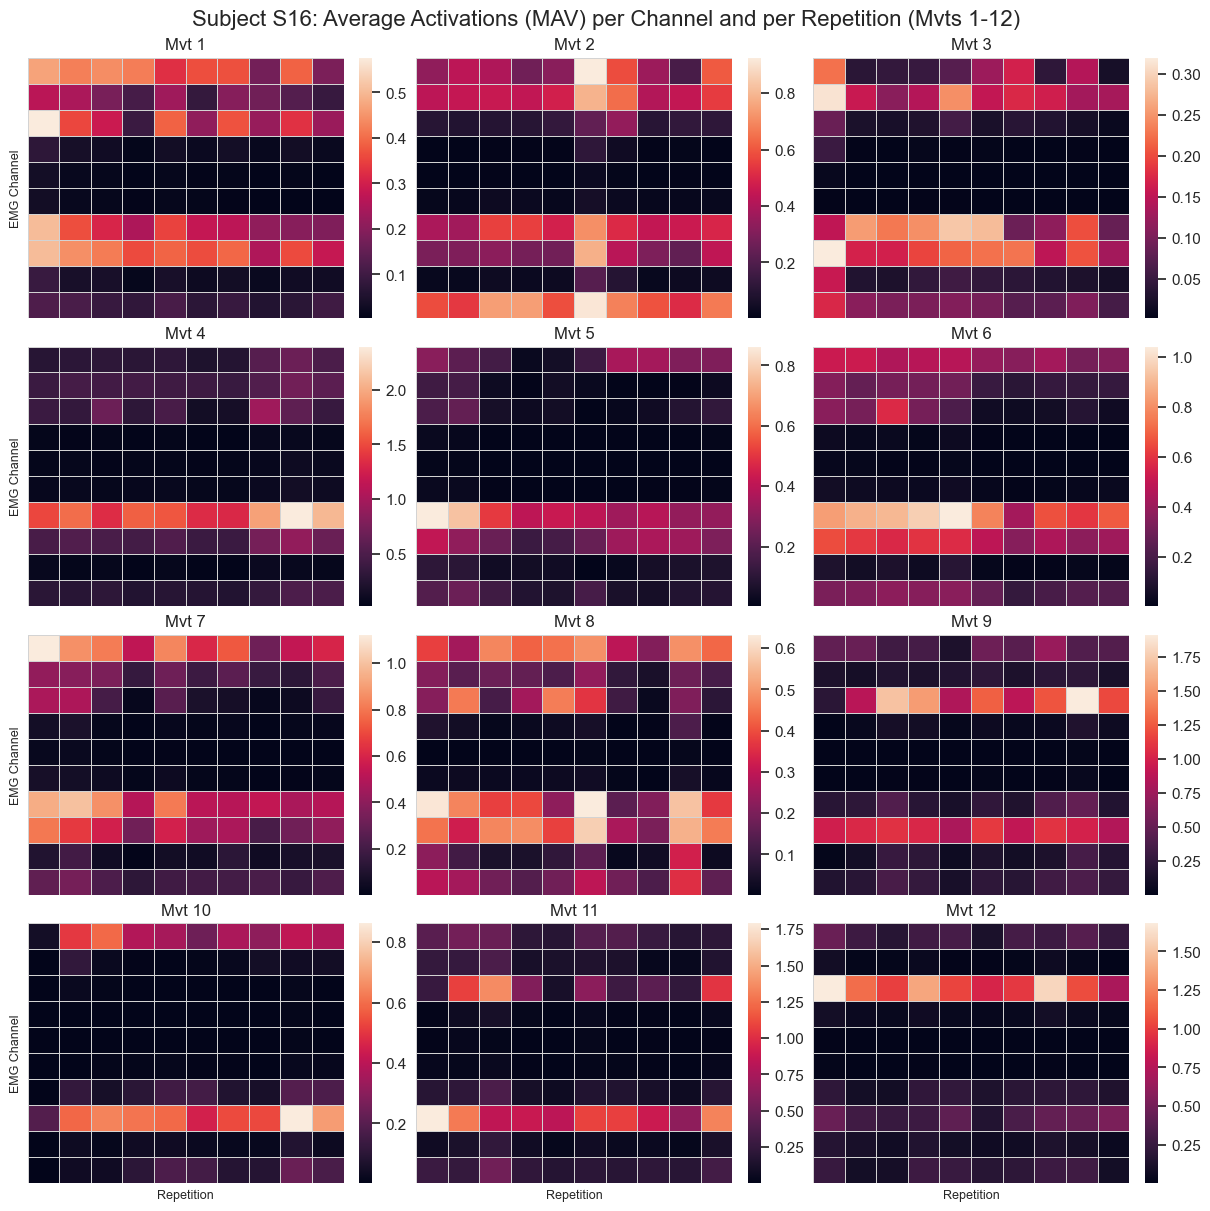

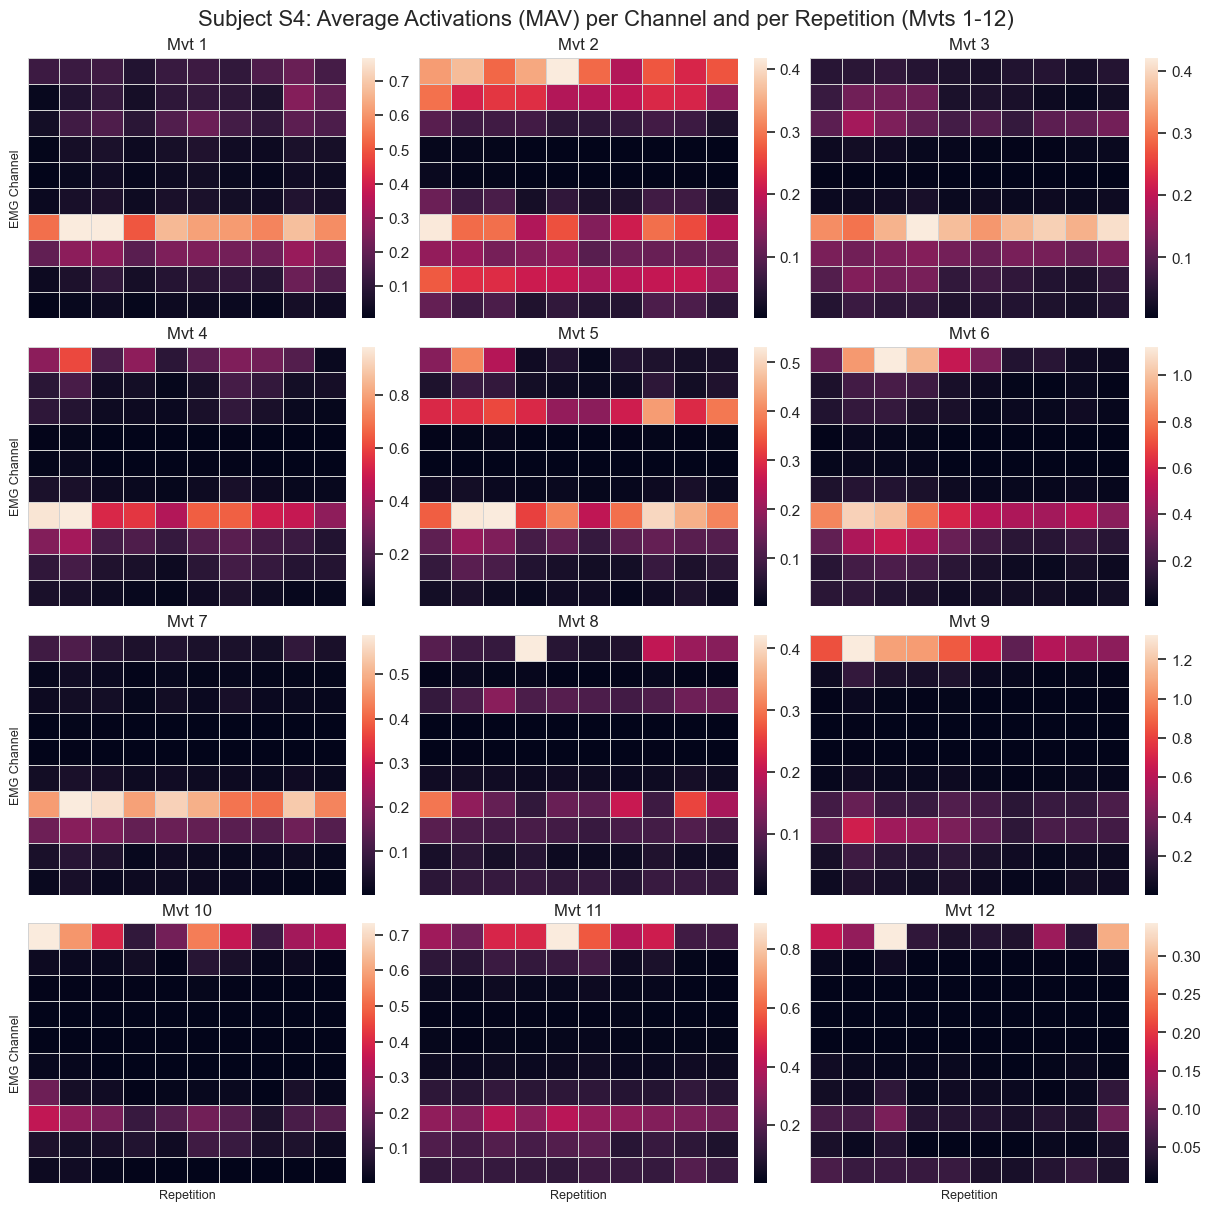

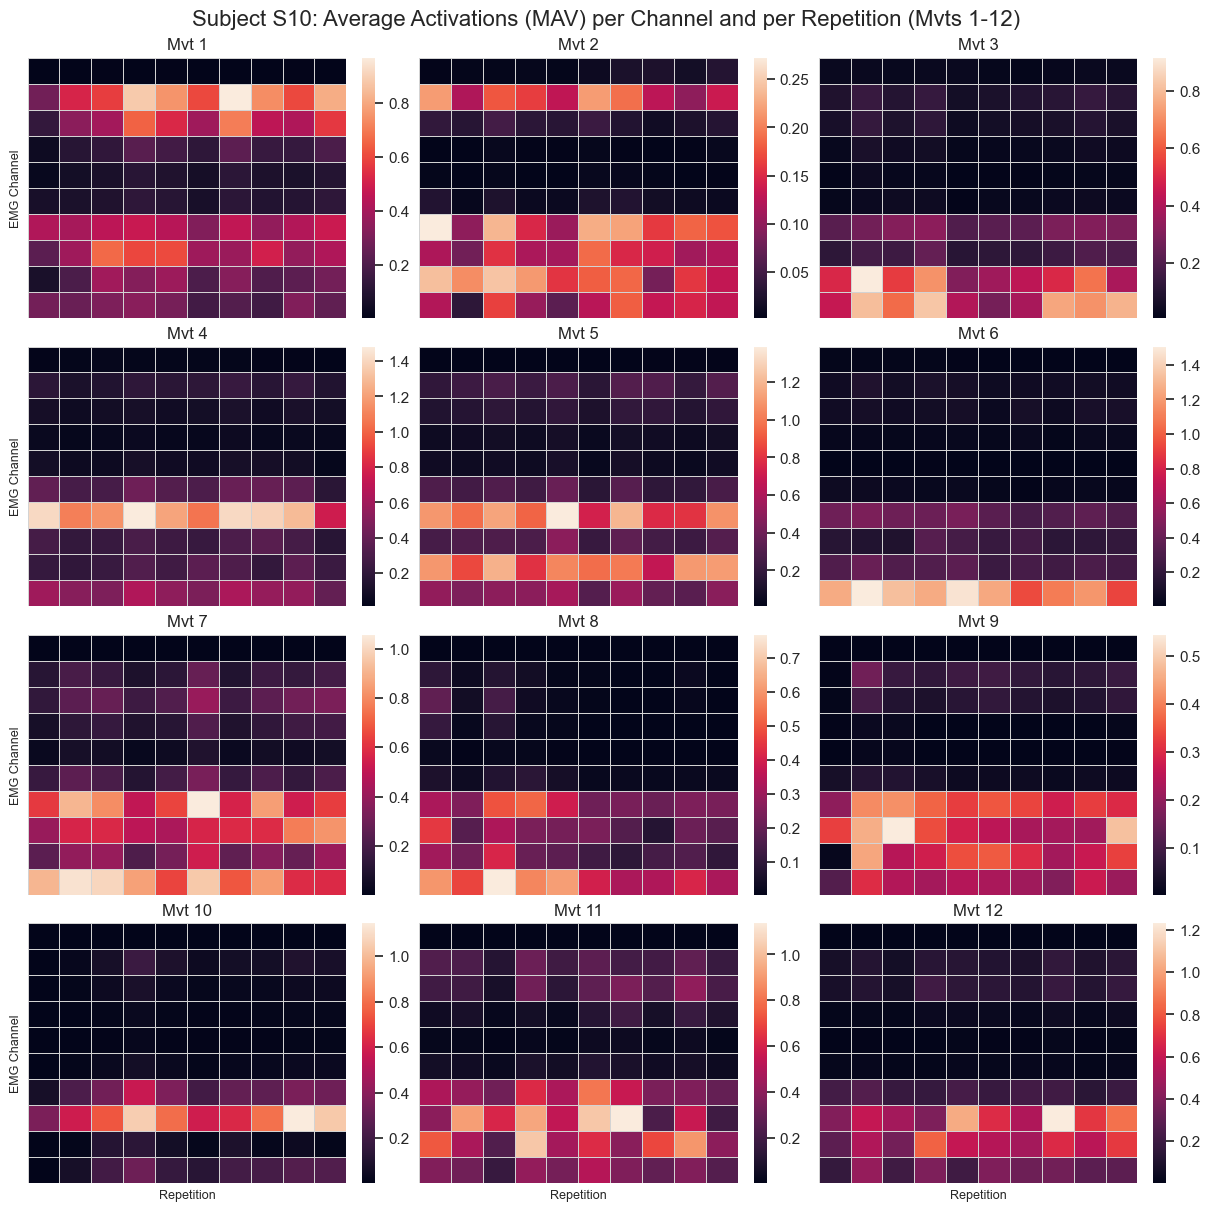

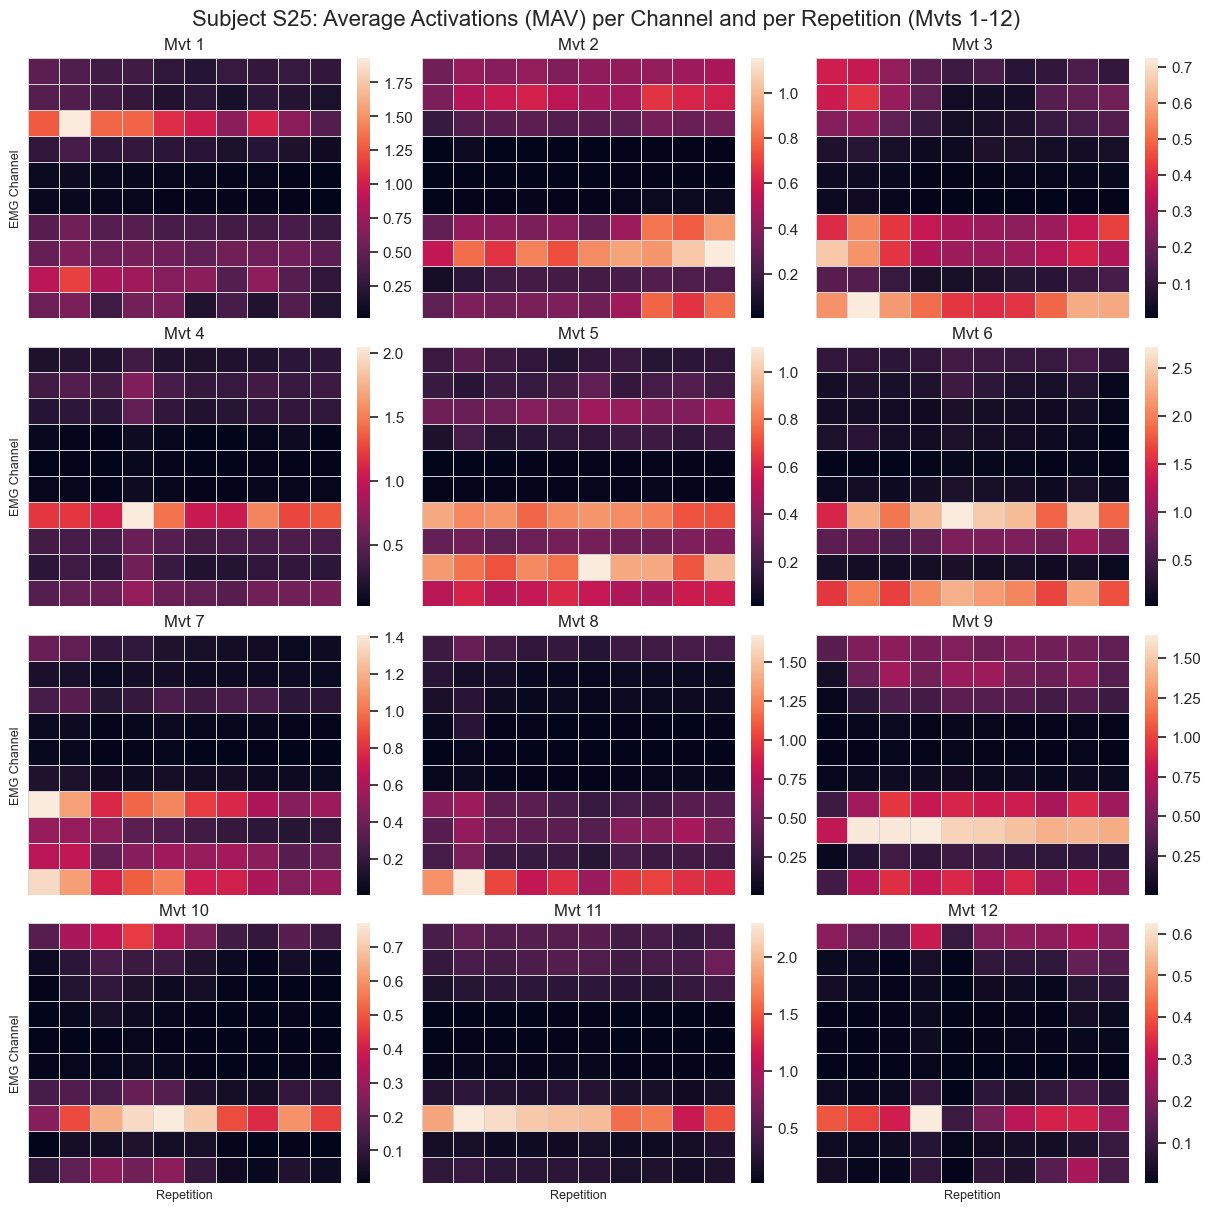

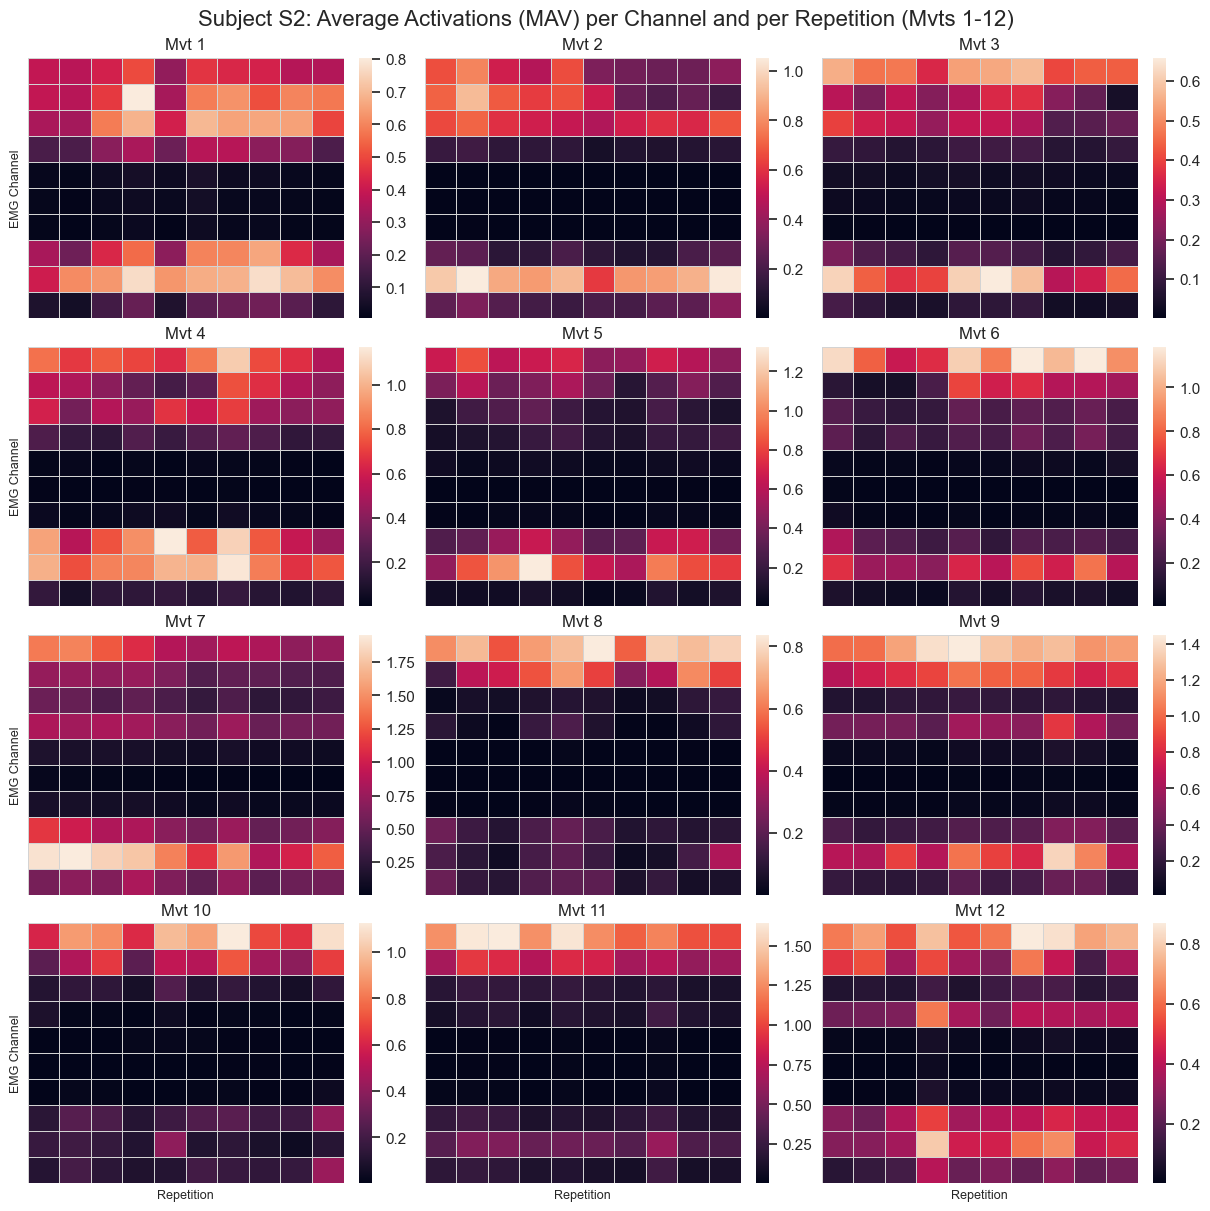

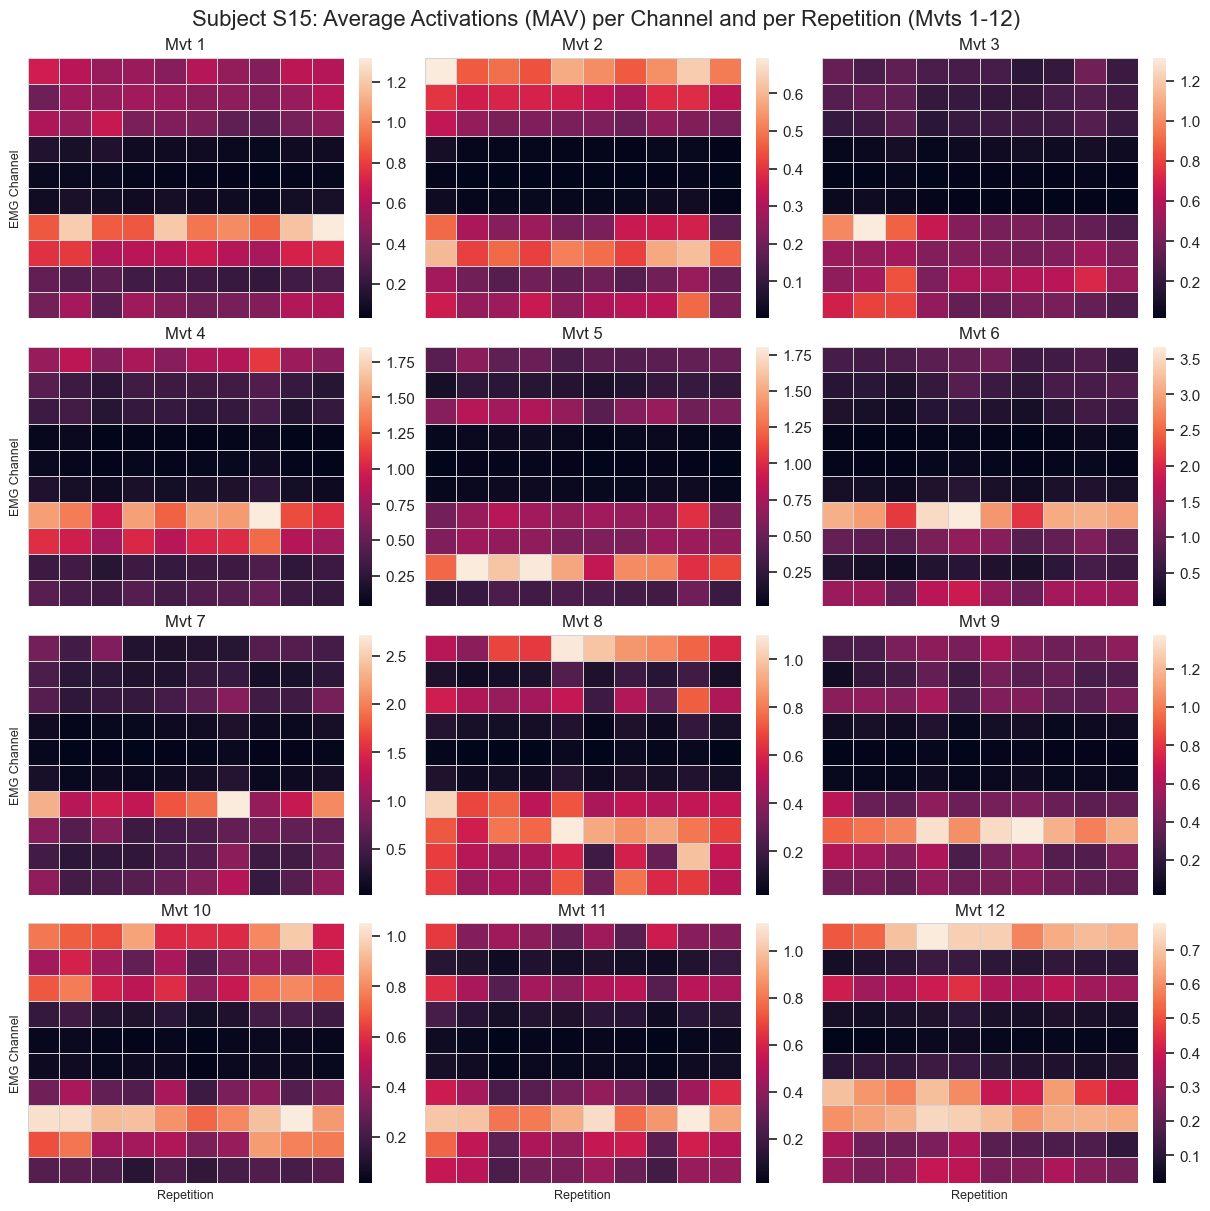

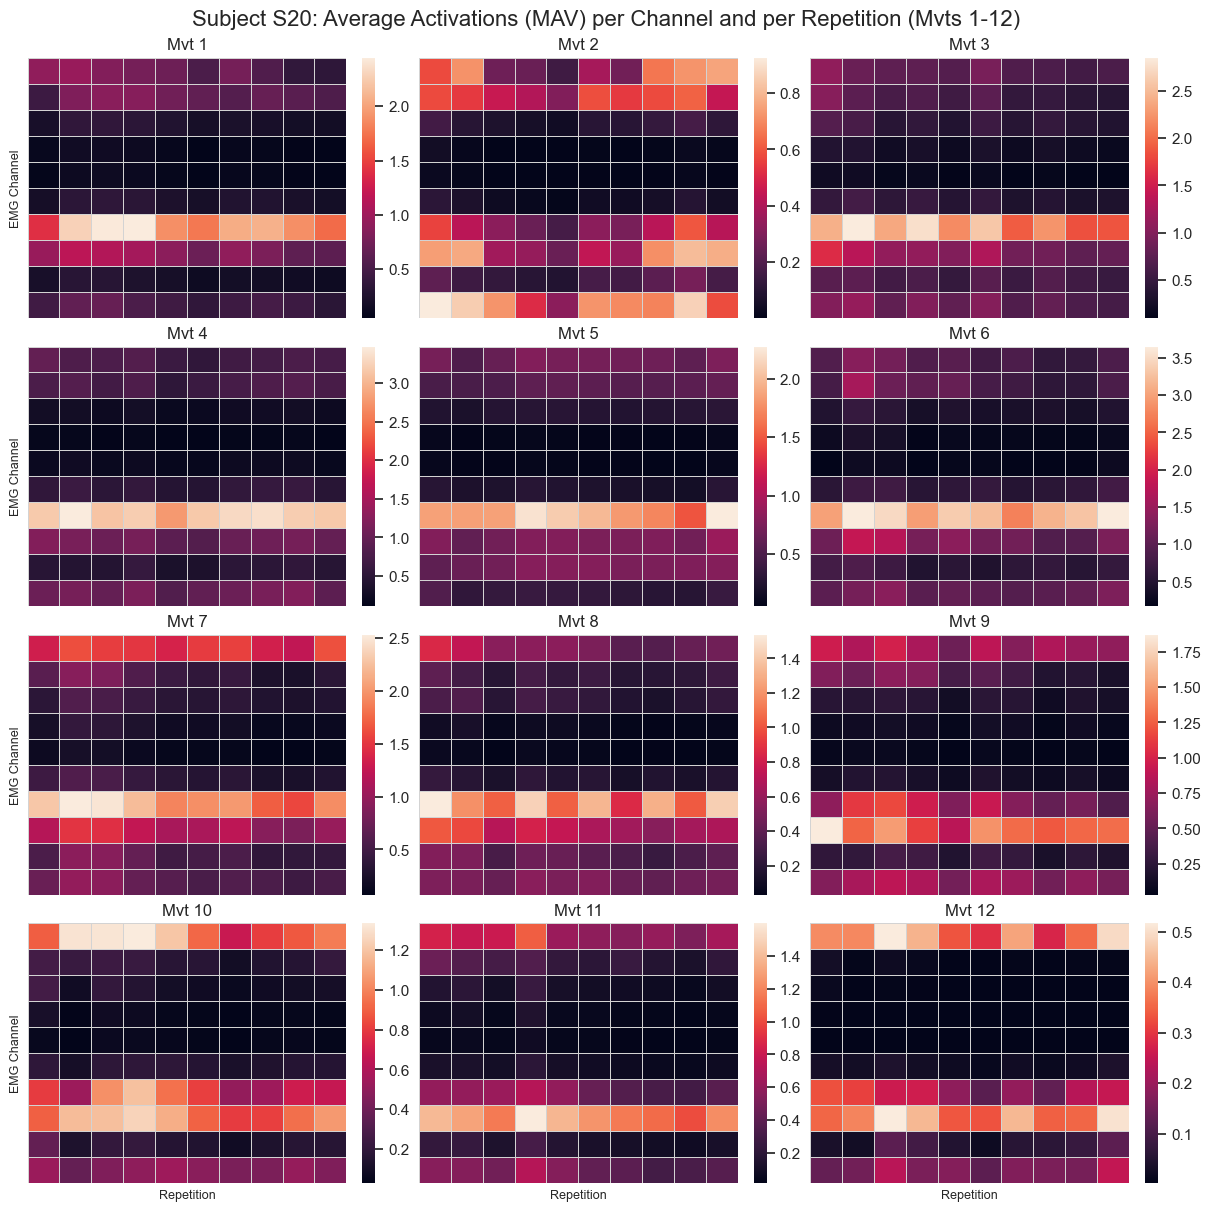

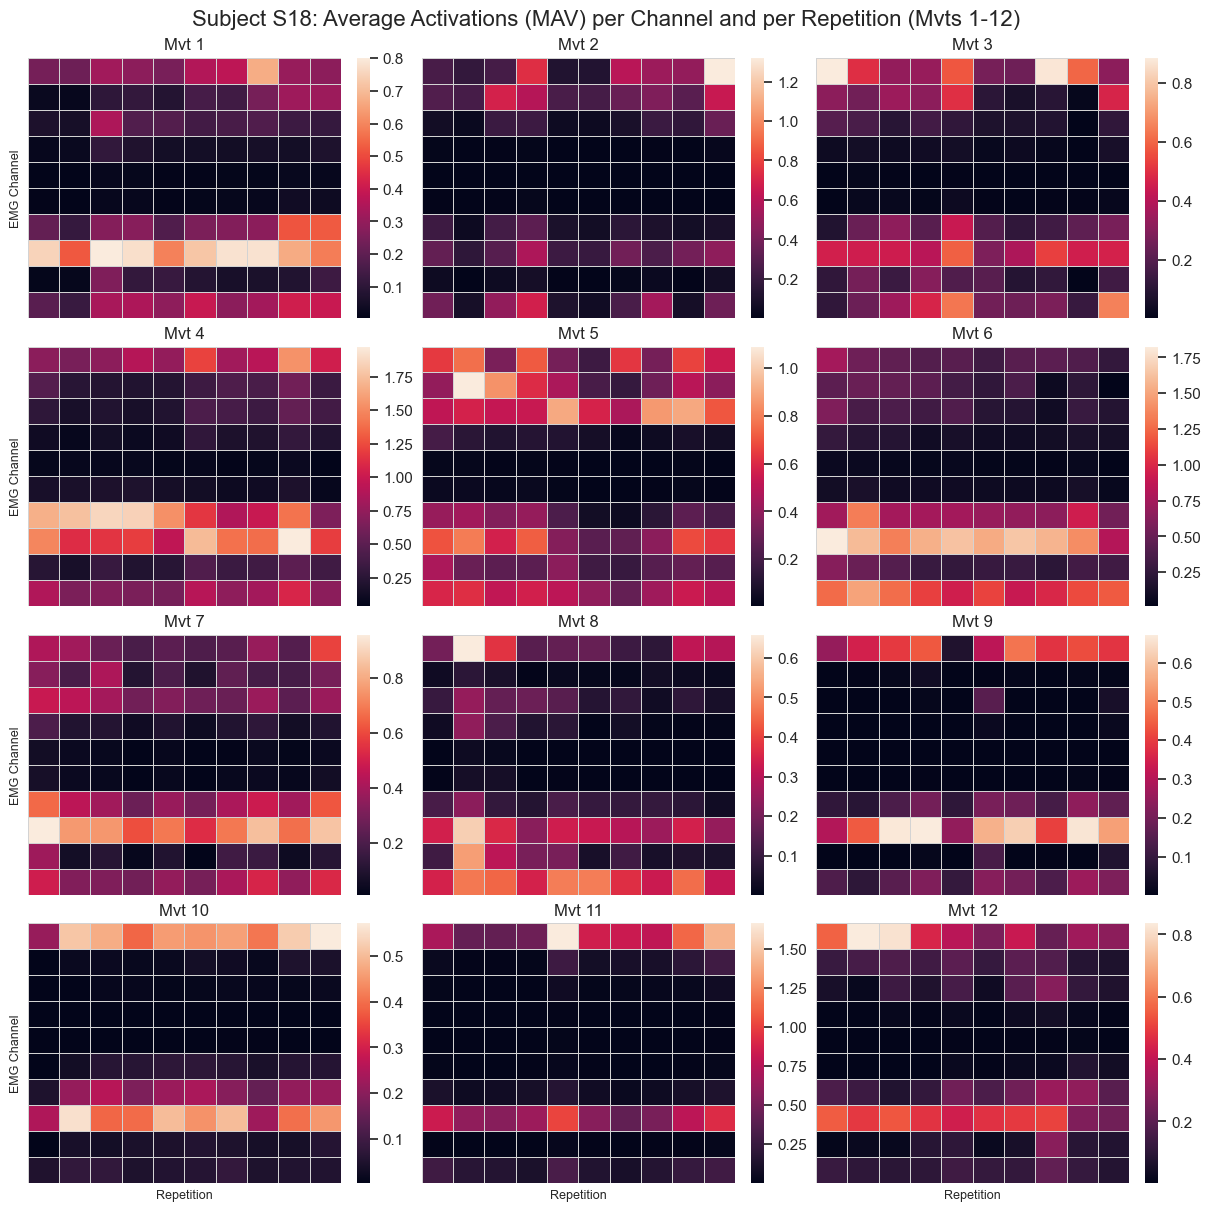

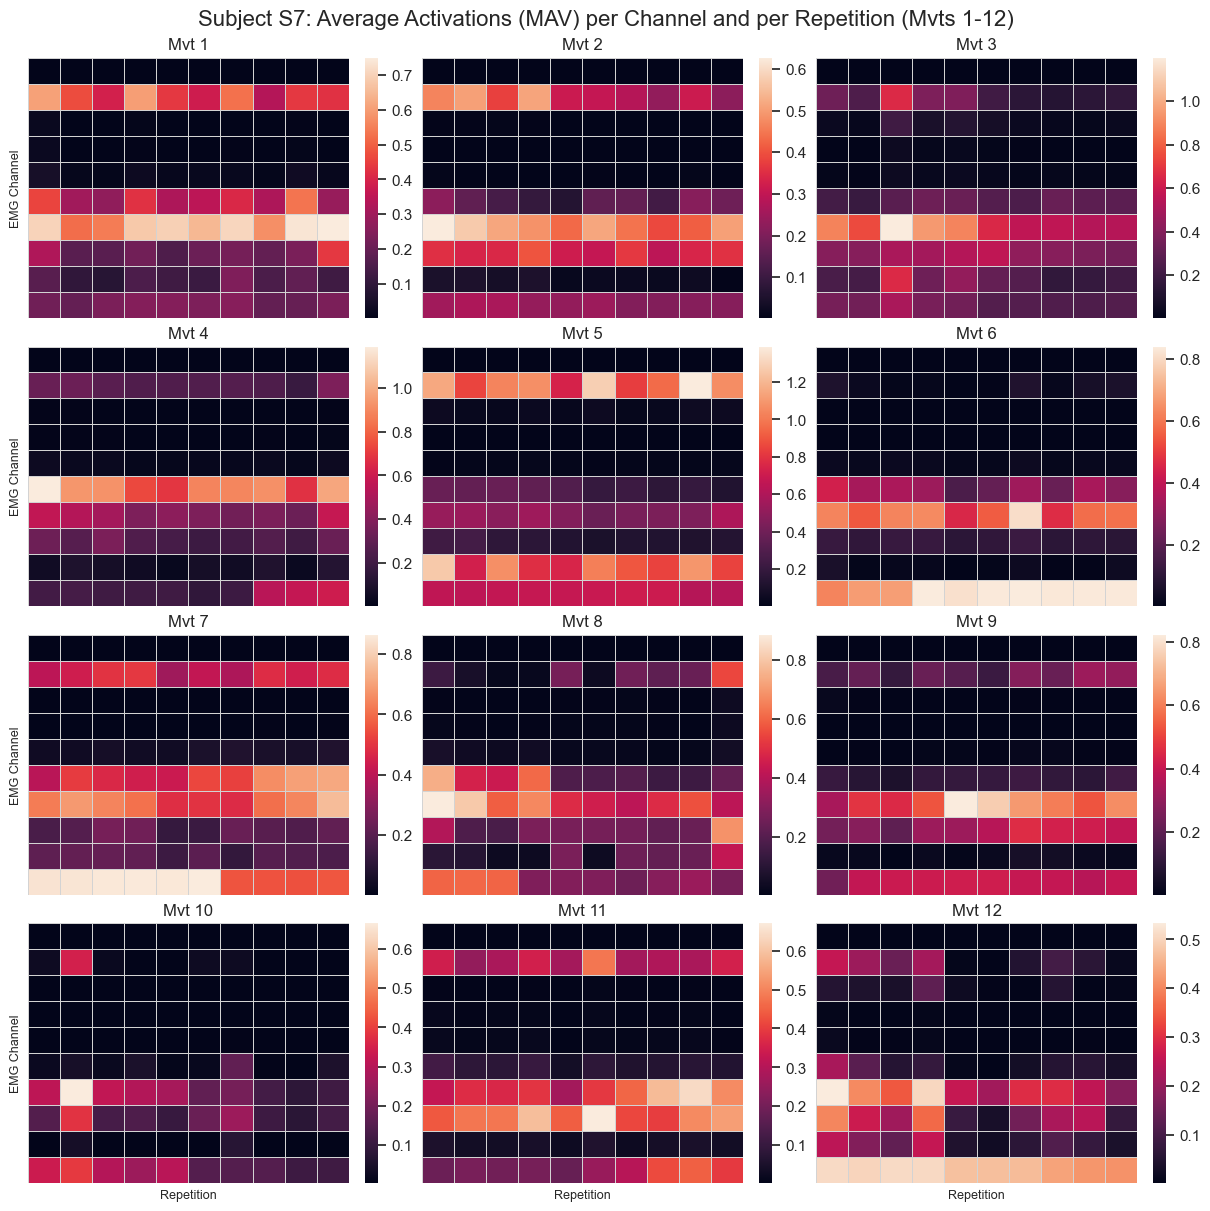

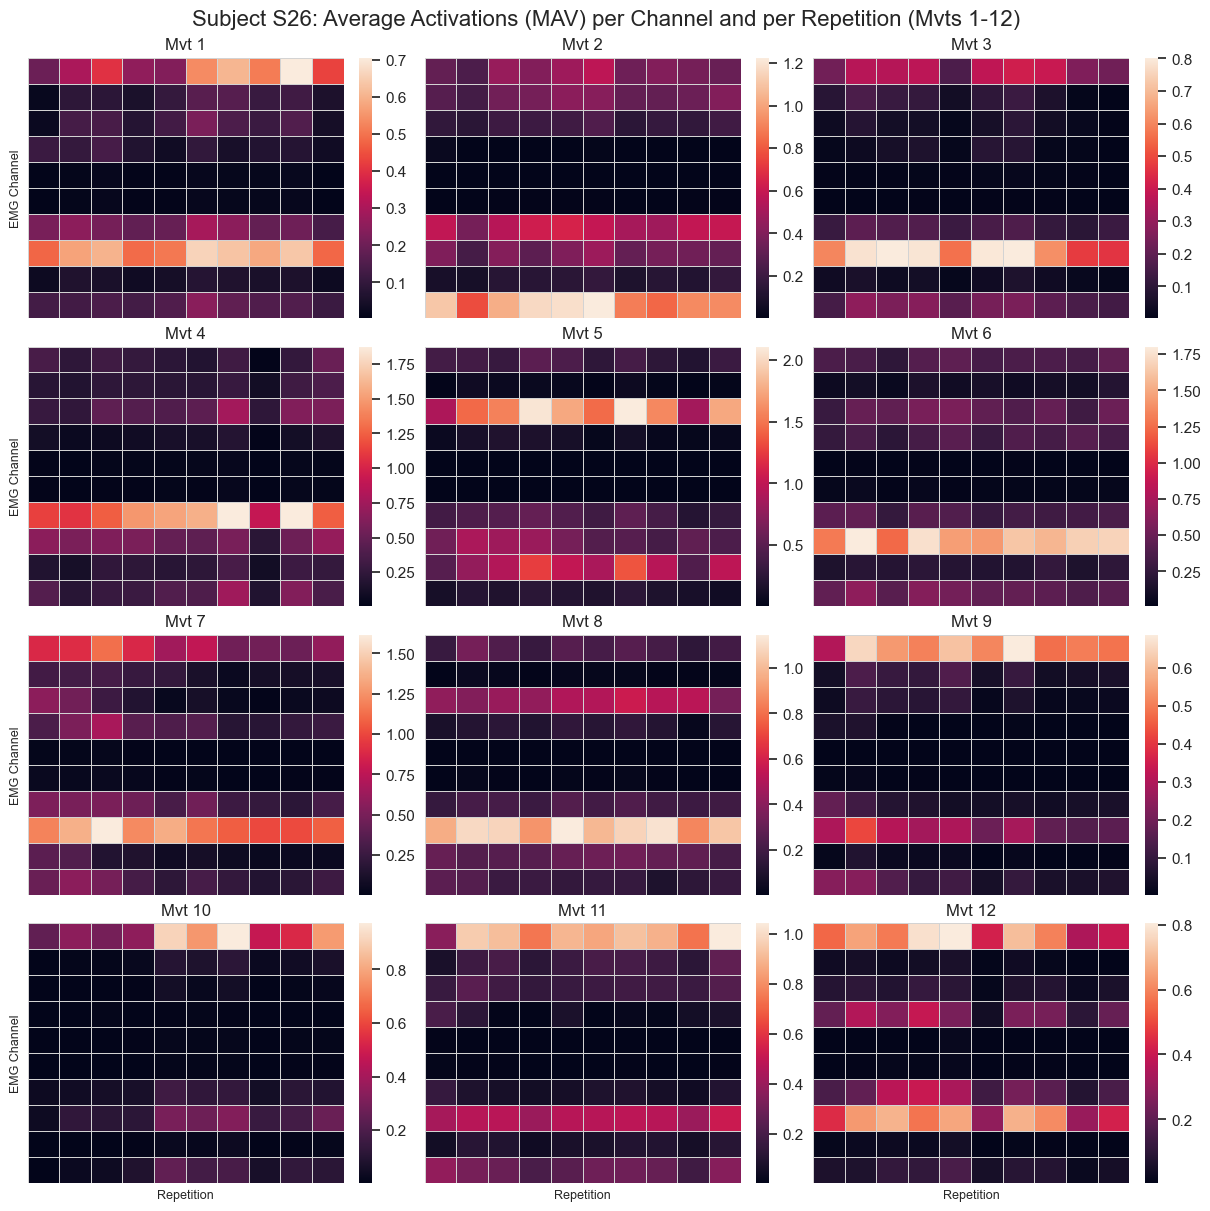

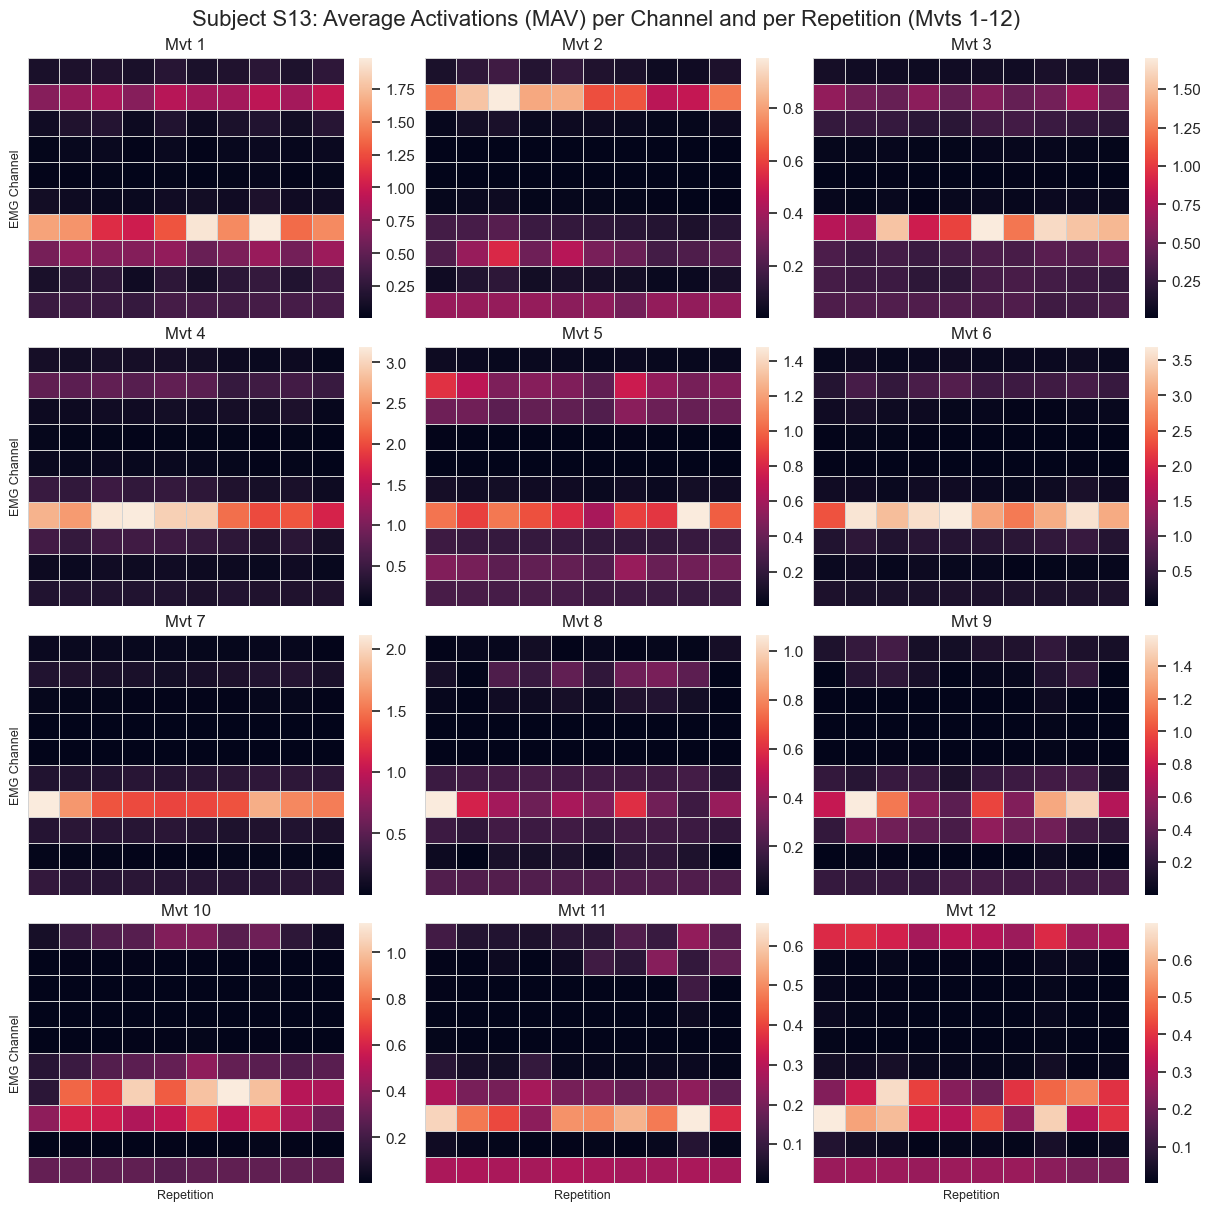

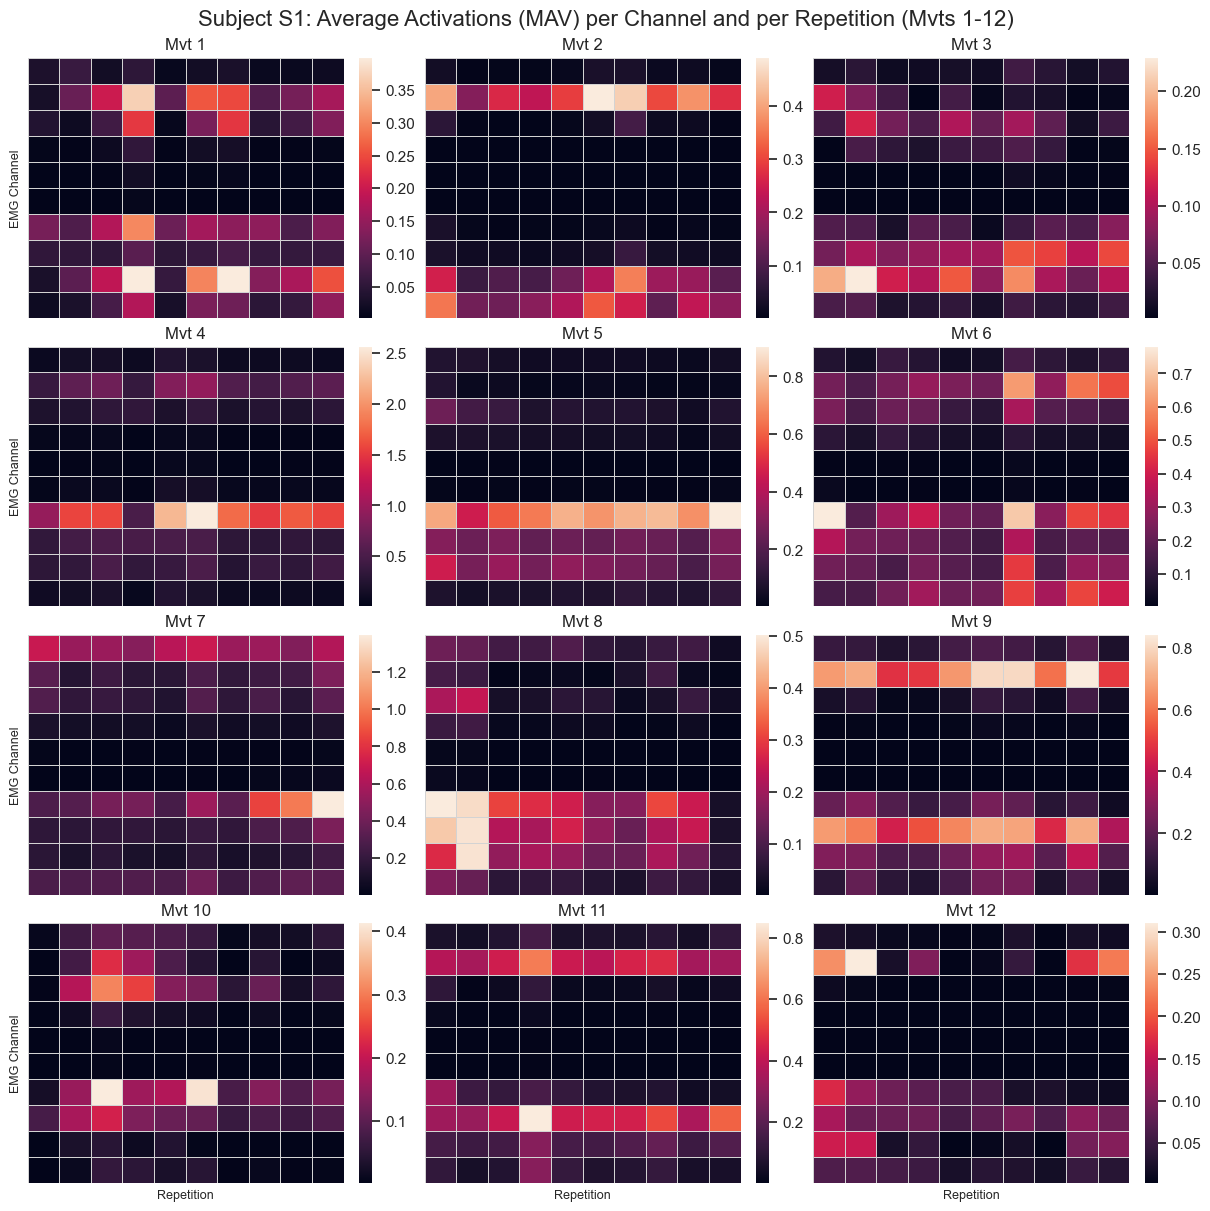

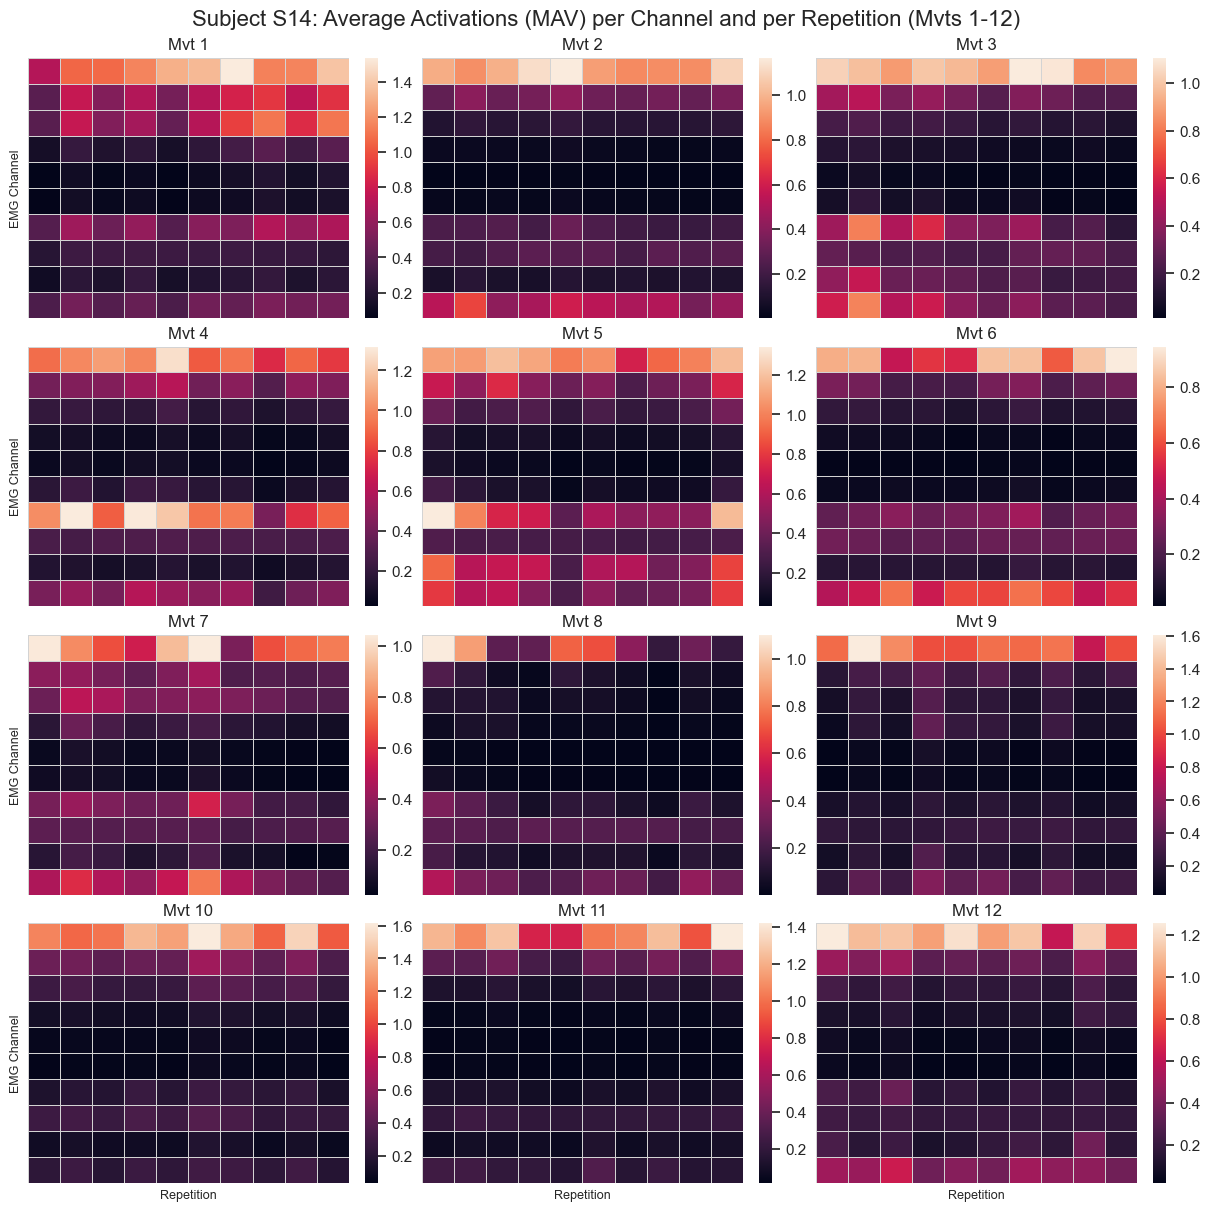

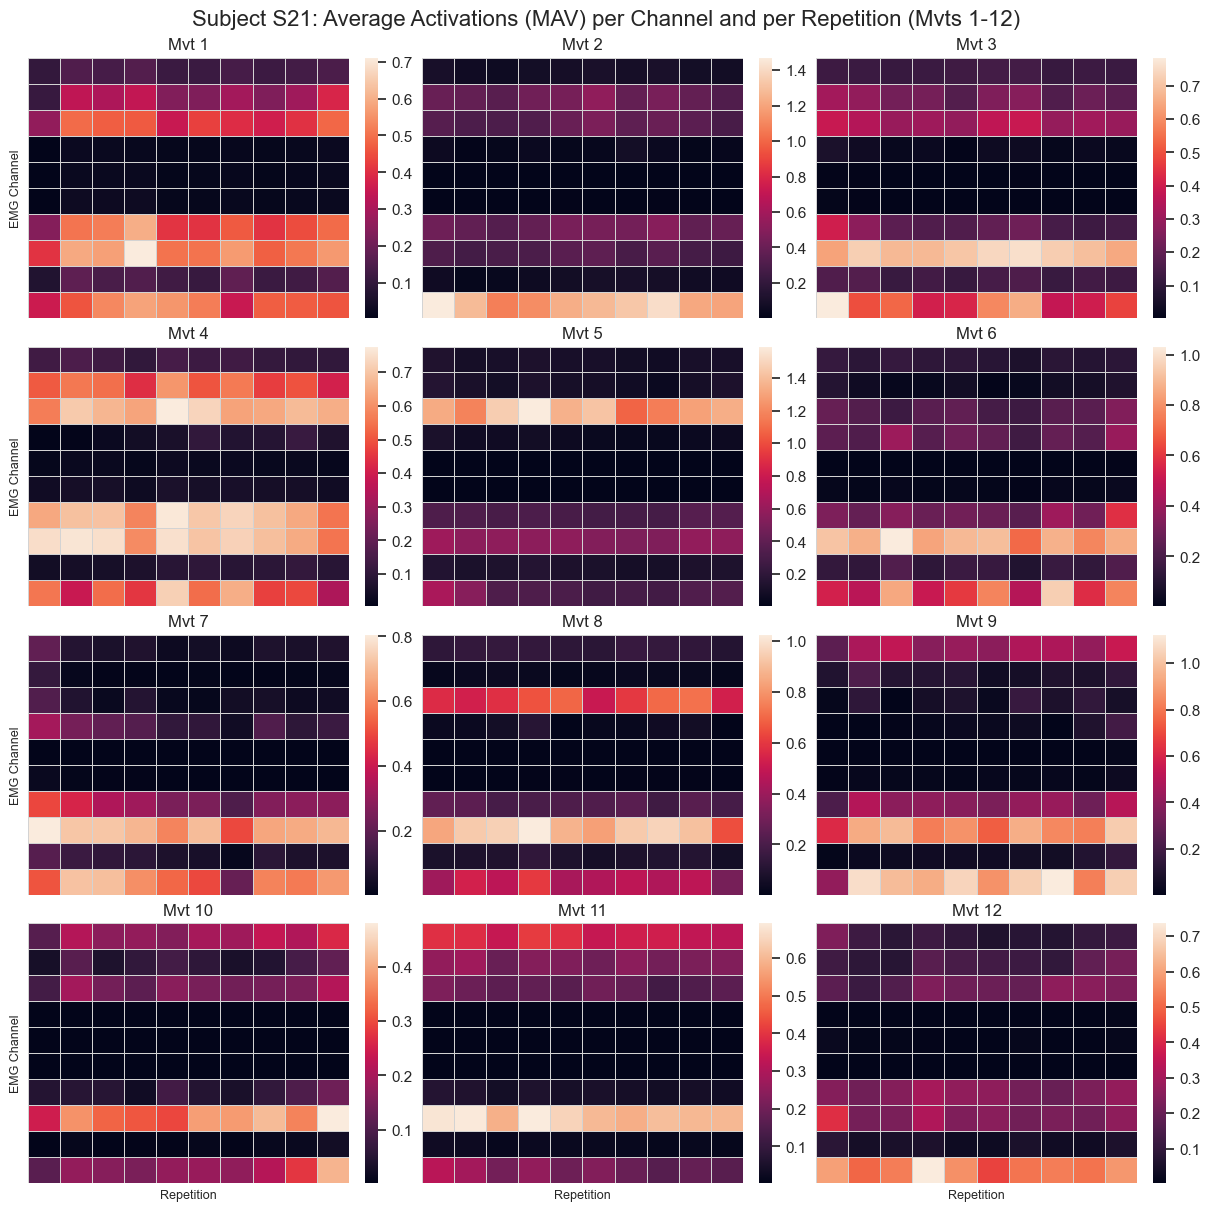

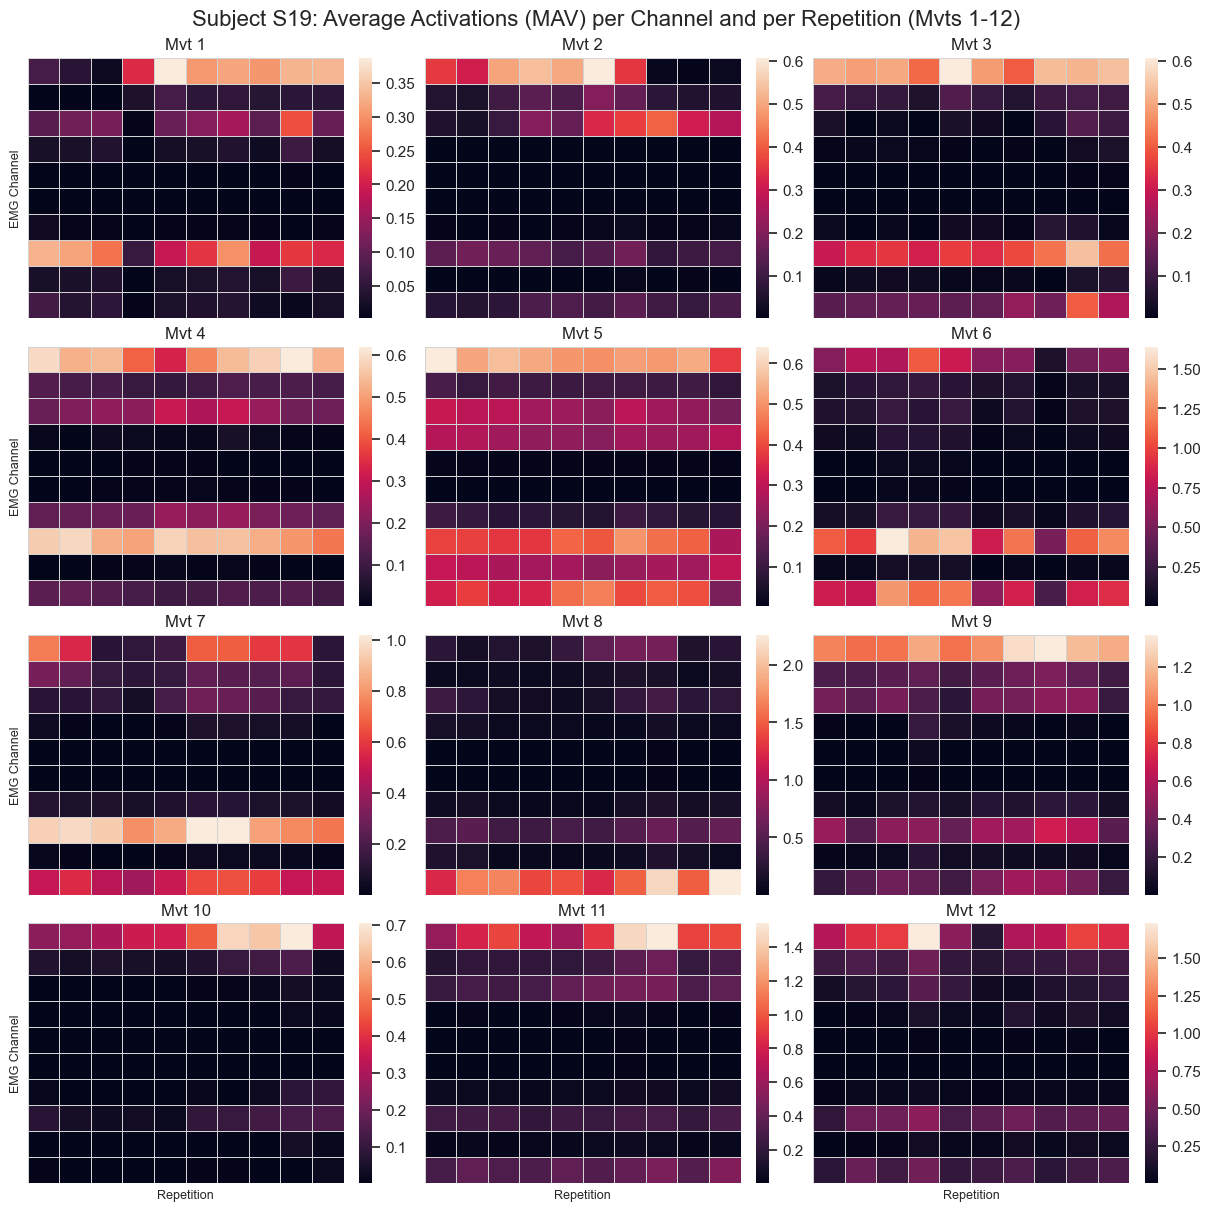

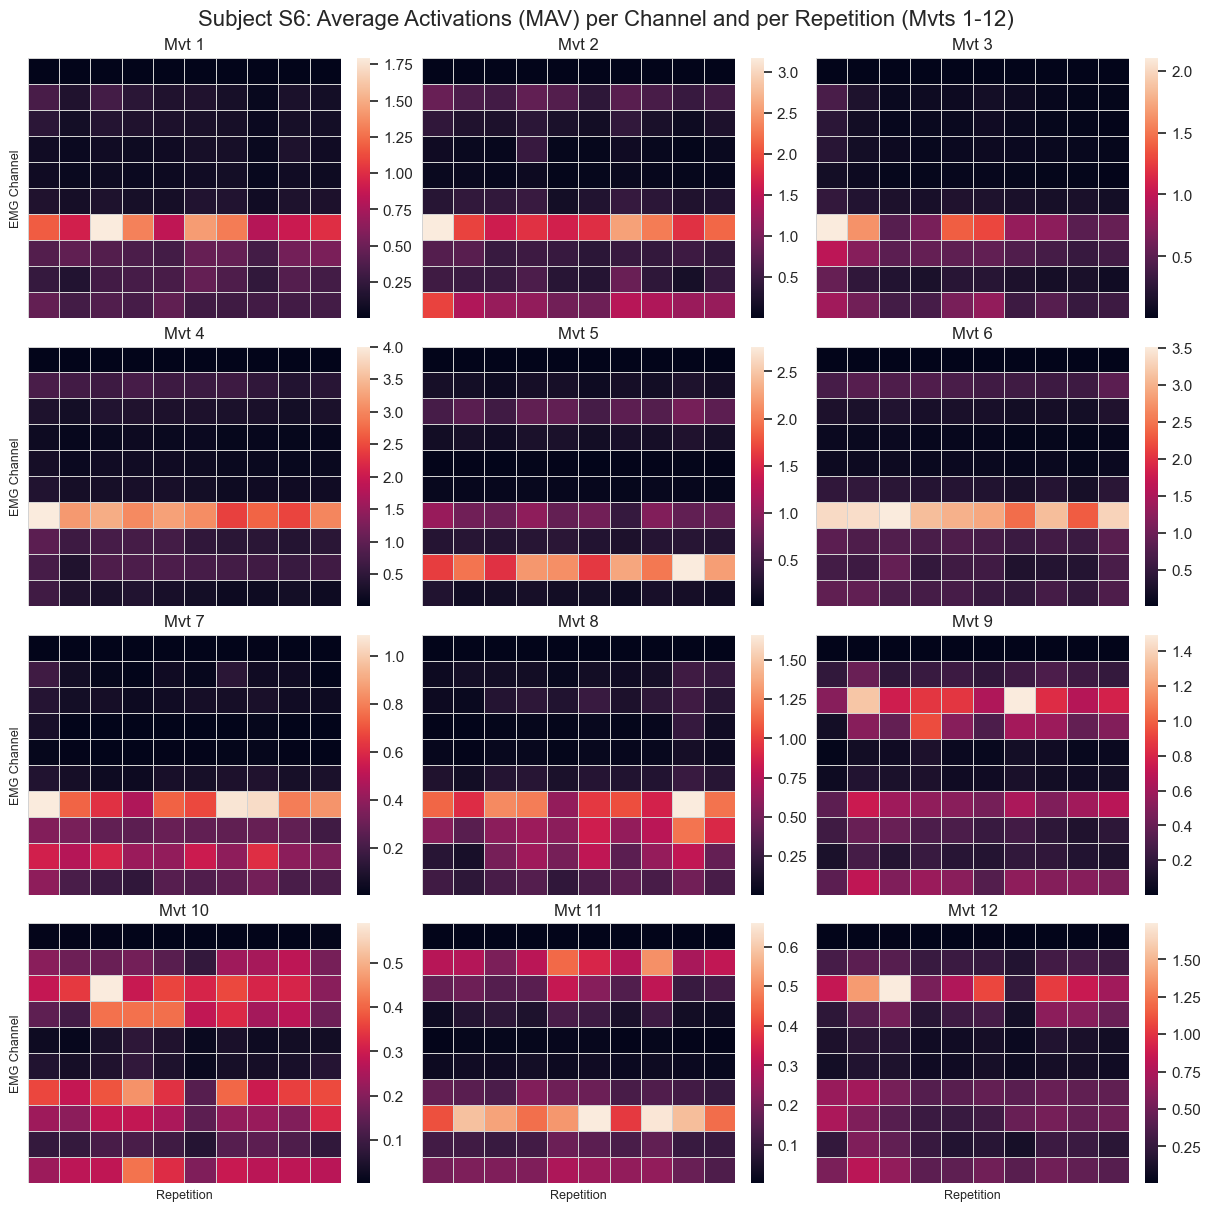

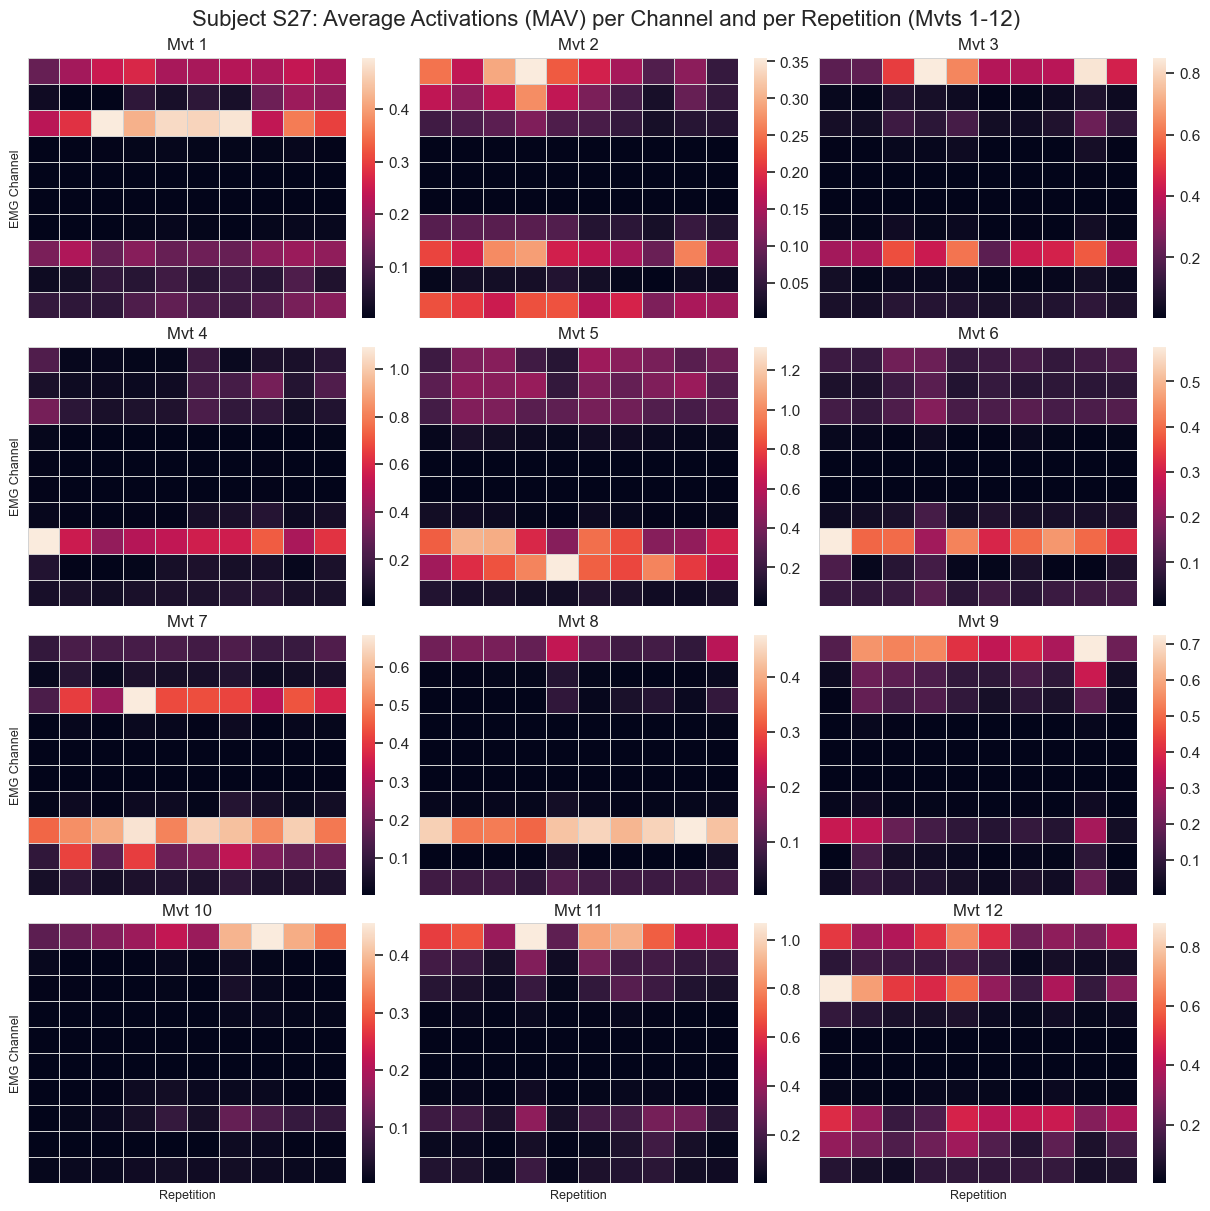

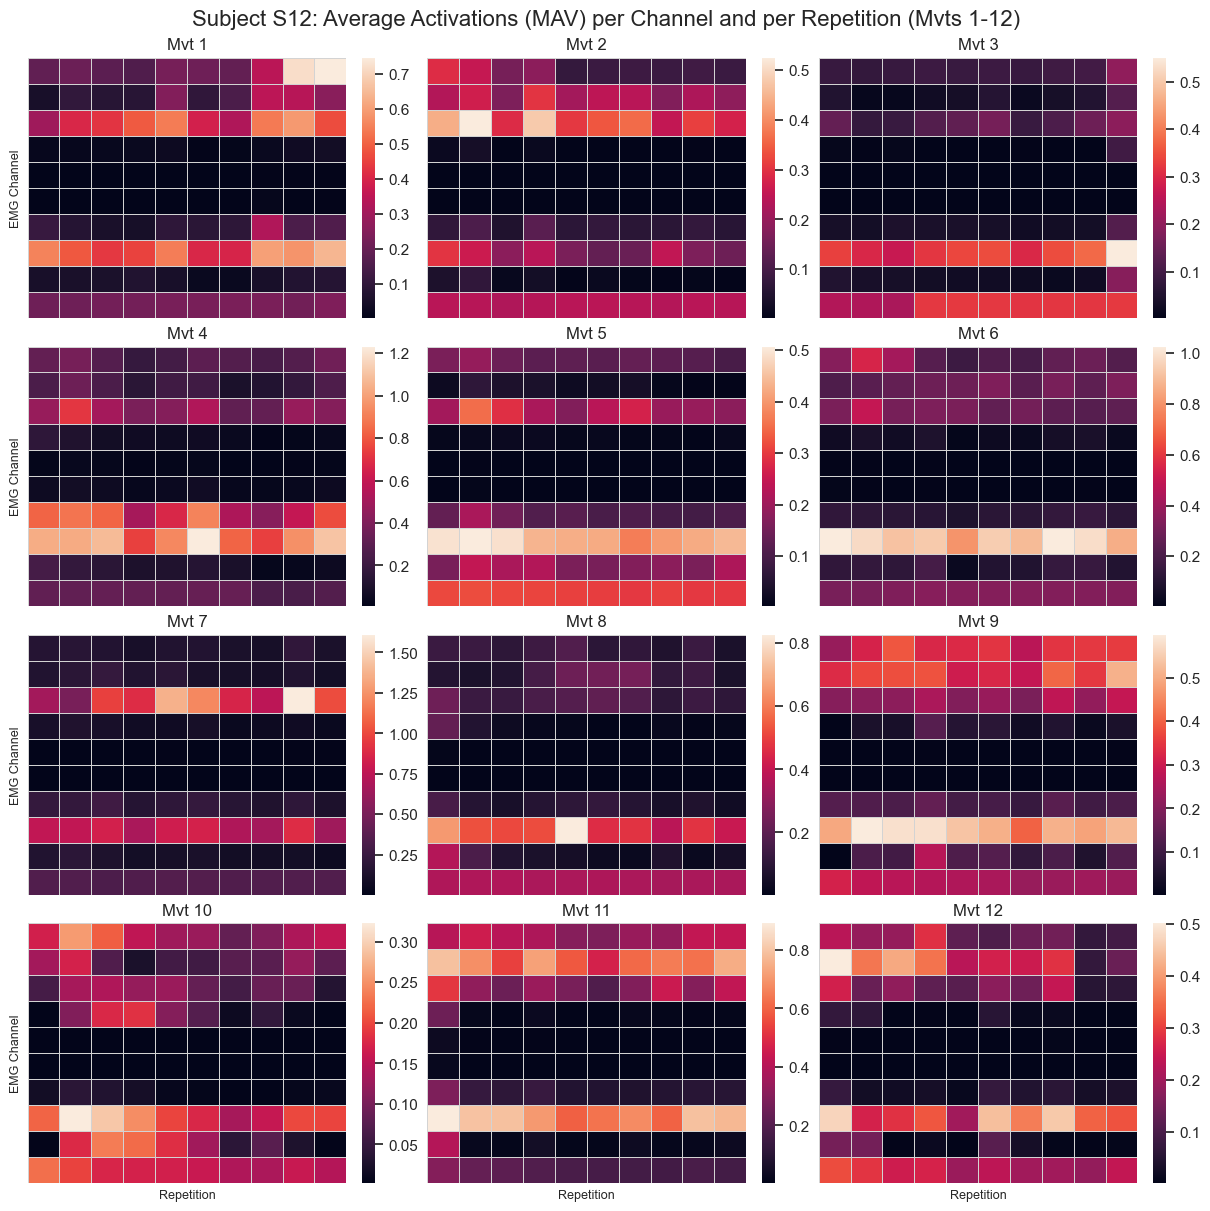

In [47]:
# Calculate and plot average activations (MAV) per channel and per repetition for all subjects

# Constant Ninapro DB1 A1
N_CHANNELS = 10

for subject in all_processed.keys():
    emg_envelopes = all_processed[subject]["emg_envelopes"]
    emg_average_activations = np.zeros((N_CHANNELS, N_STIMULI, N_REPETITIONS))

    # Calculation of average activation
    # This is equivalent to MAV (Mean Absolute Value) calculated on the envelope
    for stimuli_idx in range(N_STIMULI):
        for repetition_idx in range(N_REPETITIONS):
            window = emg_envelopes[stimuli_idx][repetition_idx]
            if window is not None and window.size > 0:
                # Calculate the temporal average for each channel
                emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(window, axis=0)
            else:
                # If the window is empty, activation remains 0
                emg_average_activations[:, stimuli_idx, repetition_idx] = 0

    fig, ax = plt.subplots(4, 3, figsize=(12, 12), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()
    
    for plot_idx in range(N_STIMULI):
        # Squeezing to get a 2D array: (Channels, Repetitions) for the current stimulus
        data_to_plot = emg_average_activations[:, plot_idx, :]
        sns.heatmap(
            data_to_plot, 
            ax=ax[plot_idx], 
            xticklabels=False, 
            yticklabels=False,
            cbar=True, 
            linewidths=0.5, linecolor='lightgray'
        )

        ax[plot_idx].title.set_text("Mvt " + str(plot_idx + 1))
        ax[plot_idx].tick_params(labelsize=8)
        
        if plot_idx % 3 == 0:
            ax[plot_idx].set_ylabel("EMG Channel", fontsize=9)
        if plot_idx >= 9:
            ax[plot_idx].set_xlabel("Repetition", fontsize=9)
        else:
            ax[plot_idx].set_xlabel("")
    
    plt.suptitle(f"Subject {subject}: Average Activations (MAV) per Channel and per Repetition (Mvts 1-12)", fontsize=16)
    plt.show()

## 3. Feature Extraction and Dataset Preparation

## 3.1 Time-Domain EMG Feature Extraction and Dataset Generation


In [48]:
# Feature Definition
# All functions take an array (EMG window) of shape (Timepoints, Channels) and return an array of shape (Channels,)

# Mean Absolute Value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0) 
# Maximum Absolute Value (MaxAV) - Peak Value
maxav = lambda x: np.max(np.abs(x), axis=0) 
# Root Mean Square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform Length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope Sign Changes (SSC) - Counts the number of times the slope changes sign (only > 0)
ssc = lambda x: np.sum(((x[1:-1] - x[:-2]) * (x[1:-1] - x[2:]) > 0), axis=0)


FEATURE_SET = [mav, std, maxav, rms, wl, ssc] 
FEATURE_NAMES = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC"]

def build_dataset_from_ninapro(emg, stimuli, repetition, features):

    n_stimuli_all = np.unique(stimuli).size 
    # Assuming Stimulus ID 0 is rest, so we subtract 1
    n_stimuli = n_stimuli_all - 1 
    # Assuming Repetition ID 0 is rest/initial phase, so we subtract 1
    n_repetitions = np.unique(repetition).size - 1
    n_samples = n_stimuli * n_repetitions
    n_channels = emg.shape[1]
    n_features_total = sum(n_channels for feature in features)
    dataset = np.zeros((n_samples, n_features_total))
    # We store the movement labels (1 to 12)
    labels = np.zeros(n_samples) 
    current_sample_index = 0
    
    for i in range(n_stimuli): 
        # Stimulus runs from 1 to 12
        current_stimulus_id = i + 1 
        
        for j in range(n_repetitions):
            # Repetition runs from 1 to 10
            current_repetition_id = j + 1 
            # Select time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimuli == current_stimulus_id, repetition == current_repetition_id).squeeze()
            # We must check if the window contains data (if duration > 0)
            window_data = emg[selected_tsteps, :]
            
            if window_data.shape[0] > 0:
                # Label Assignment
                labels[current_sample_index] = current_stimulus_id 
                current_feature_index = 0

                # Feature Extraction
                for feature in features:
                    selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                    # Calculate and store the feature
                    dataset[current_sample_index, selected_features] = feature(window_data)
                    current_feature_index += n_channels   
                # Move to the next sample
                current_sample_index += 1

    # Resize the arrays to the actual number of samples 
    dataset = dataset[:current_sample_index, :]
    labels = labels[:current_sample_index]
    
    return dataset, labels

## 3.2 Per-Subject Feature Extraction, Normalization, and Dataset Aggregation


In [49]:
all_datasets = []
all_labels = []
all_subject_ids = []

print("--- Feature Extraction per Subject ---")
subject_scaler = StandardScaler()

for subject_id, data in all_processed.items():
    emg = data["emg"]
    
    stimuli = data["stimulus"] 
    repetition = data["repetition"]
    
    # Builds the dataset for the current subject
    dataset_sub, labels_sub = build_dataset_from_ninapro(
        emg=emg,
        stimuli=stimuli, 
        repetition=repetition,
        features=FEATURE_SET
    )
    
    if dataset_sub.shape[0] > 0:
        # Important: We normalize per subject !!
        dataset_sub_scaled = subject_scaler.fit_transform(dataset_sub) 
        all_datasets.append(dataset_sub_scaled) 
        all_labels.append(labels_sub)
        subject_id_array = np.full(dataset_sub.shape[0], int(subject_id.replace('S', '')))
        all_subject_ids.append(subject_id_array)
        
        print(f"Subject {subject_id}: {dataset_sub.shape[0]} samples extracted and normalized (Z-score).")
    else:
        print(f"Subject {subject_id}: 0 valid samples (Skipped).")

# Final aggregation of all data
X_full = np.concatenate(all_datasets, axis=0)
y_full = np.concatenate(all_labels, axis=0)
Z_subject = np.concatenate(all_subject_ids, axis=0) 

print(f"\n--- Aggregated Dataset ---")
print(f"X_full (Total Features): {X_full.shape}")
print(f"y_full (Total Labels): {y_full.shape}")
print(f"Z_subject (Total Subject IDs): {Z_subject.shape}")
print("-" * 40)

--- Feature Extraction per Subject ---
Subject S22: 120 samples extracted and normalized (Z-score).
Subject S8: 120 samples extracted and normalized (Z-score).
Subject S17: 120 samples extracted and normalized (Z-score).
Subject S5: 120 samples extracted and normalized (Z-score).
Subject S11: 120 samples extracted and normalized (Z-score).
Subject S24: 120 samples extracted and normalized (Z-score).
Subject S3: 120 samples extracted and normalized (Z-score).
Subject S9: 120 samples extracted and normalized (Z-score).
Subject S23: 120 samples extracted and normalized (Z-score).
Subject S16: 120 samples extracted and normalized (Z-score).
Subject S4: 120 samples extracted and normalized (Z-score).
Subject S24: 120 samples extracted and normalized (Z-score).
Subject S3: 120 samples extracted and normalized (Z-score).
Subject S9: 120 samples extracted and normalized (Z-score).
Subject S23: 120 samples extracted and normalized (Z-score).
Subject S16: 120 samples extracted and normalized (Z-

## 3.3 Subject-Wise ANOVA Feature Relevance Analysis


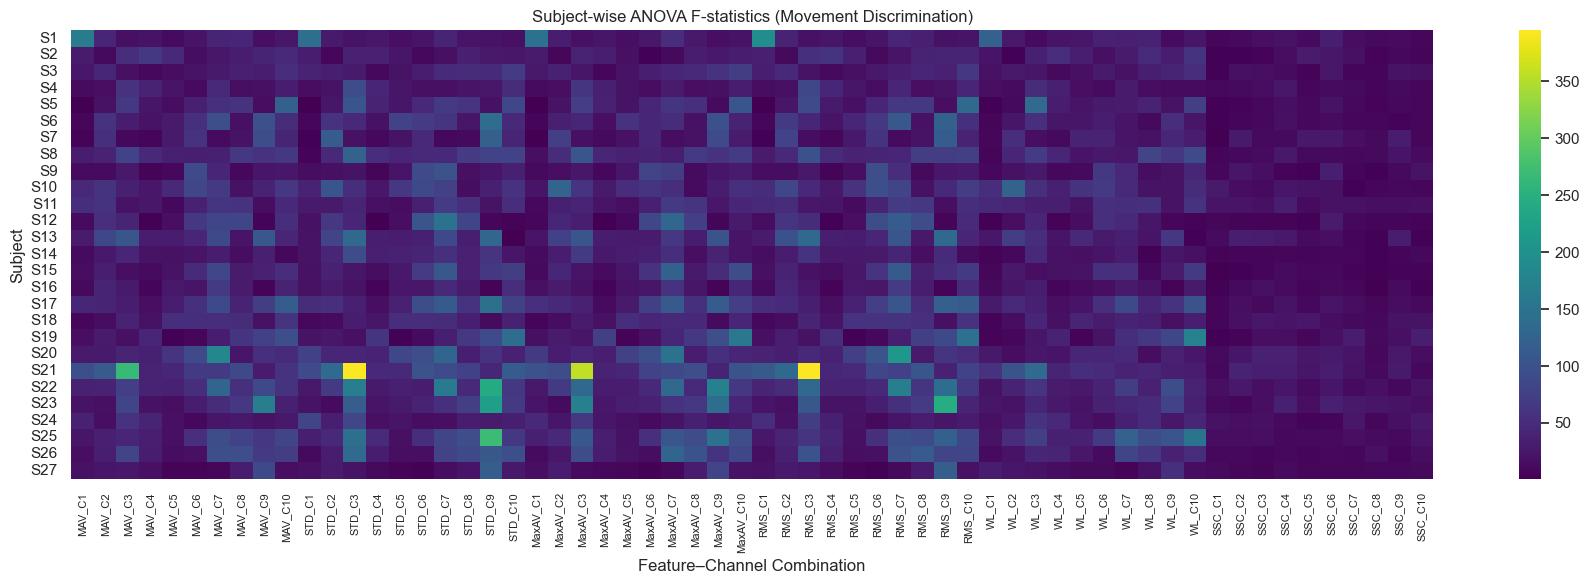

In [50]:
# Number of subjects and total features
subject_ids = np.unique(Z_subject)
n_subjects = len(subject_ids)
n_total_features = X_full.shape[1]

# Matrix to store F-values: (subjects × feature-channel combinations)
F_subjects = np.zeros((n_subjects, n_total_features))

# Subject-wise ANOVA
for i, subj in enumerate(subject_ids):
    # Select samples from one subject
    subj_mask = Z_subject == subj
    X_subj = X_full[subj_mask]
    y_subj = y_full[subj_mask]
    # Compute ANOVA for this subject
    F_vals, _ = f_classif(X_subj, y_subj)
    F_subjects[i, :] = F_vals

# Reconstruct Feature–Channel names
feature_names_full = []
for f_name in FEATURE_NAMES:
    for c_id in range(1, N_CHANNELS + 1):
        feature_names_full.append(f"{f_name}_C{c_id}")

# Heatmap 
plt.figure(figsize=(18, 6))
sns.heatmap(
    F_subjects,
    cmap="viridis",
    xticklabels=feature_names_full,
    yticklabels=[f"S{subj}" for subj in subject_ids]
)
plt.title("Subject-wise ANOVA F-statistics (Movement Discrimination)")
plt.xlabel("Feature–Channel Combination")
plt.ylabel("Subject")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()



## 4. Classification Model Training

In [51]:
# Choose the test subject
test_subject_id = 27 
param_grid = {
    "n_estimators": [40, 50, 60, 100, 150, 200],
    "max_depth": [4, 5, 6, 8, 10],
    "min_samples_split": [2, 4, 6, 8],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ["log2", "sqrt"]
}

# Create boolean masks based on Z_subject
mask_test = (Z_subject == test_subject_id)
mask_train = (Z_subject != test_subject_id)
# Apply masks to split X and y
X_train_q3 = X_full[mask_train]
y_train_q3 = y_full[mask_train]
X_test_q3 = X_full[mask_test]
y_test_q3 = y_full[mask_test]

print(f"Test Subject: {test_subject_id}")
print(f"Train Size (26 subjects): {X_train_q3.shape}")
print(f"Test Size (1 subject): {X_test_q3.shape}")

# Base model
rf_base = RandomForestClassifier(random_state=42)
# GridSearchCV Initialization
# cv=3 means 3-fold cross-validation on the TRAIN set
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,                      
    scoring="accuracy",        
    n_jobs=-1,                 
    verbose=0                  
)

print("\n--- Starting Grid Search ---")
start_time = time.time()
# Training and search for best parameters (on the TRAIN set)
grid_search.fit(X_train_q3, y_train_q3) 
end_time = time.time()

print(f"Grid Search execution time: {end_time - start_time:.2f} seconds")
print("-" * 50)

# Retrieve the best model found by the Grid Search
best_clf = grid_search.best_estimator_

print("Best parameters found:", grid_search.best_params_)
print(f"Best CV Accuracy (on Train): {grid_search.best_score_:.4f}")

# Evaluation on the Test Subject 
acc_q3_tuned = best_clf.score(X_test_q3, y_test_q3)

print("\n--- Final Model Evaluation ---")
print(f"Accuracy on Subject {test_subject_id} (new subject): {acc_q3_tuned:.4f}")

Test Subject: 27
Train Size (26 subjects): (3120, 60)
Test Size (1 subject): (120, 60)

--- Starting Grid Search ---
Grid Search execution time: 195.49 seconds
--------------------------------------------------
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best CV Accuracy (on Train): 0.4503

--- Final Model Evaluation ---
Accuracy on Subject 27 (new subject): 0.3500
Grid Search execution time: 195.49 seconds
--------------------------------------------------
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best CV Accuracy (on Train): 0.4503

--- Final Model Evaluation ---
Accuracy on Subject 27 (new subject): 0.3500


## 5. Leave-One-Subject-Out Cross-Validation (Question 4)

In [52]:
print("\n--- Question 4: Leave-One-Subject-Out Cross-Validation ---")

unique_subjects = np.unique(Z_subject)
accuracies = []
# Model (We use the best parameters found in previous GridSearch)
rf_params = {
    'n_estimators': 150,     
    'max_depth': 10,         
    "min_samples_split": 8,  # Minimum number of samples required to split an internal node
    "max_features": 'log2',
    'min_samples_leaf': 1,
    'n_jobs': -1,
    'random_state': 42
}

# Initialize the scaler once (it will be re-initialized and fit inside the loop)
scaler = StandardScaler() 

for sub_id in unique_subjects:
    # Splitting
    mask_test = (Z_subject == sub_id)
    mask_train = ~mask_test # The inverse of the test mask (all other subjects)
    
    X_train_cv = X_full[mask_train]
    y_train_cv = y_full[mask_train]
    
    X_test_cv = X_full[mask_test]
    y_test_cv = y_full[mask_test]
    
    # Training
    clf = RandomForestClassifier(**rf_params)
    clf.fit(X_train_cv, y_train_cv) 
    
    # Prediction and Score
    y_pred = clf.predict(X_test_cv) 
    acc = accuracy_score(y_test_cv, y_pred)
    
    accuracies.append(acc)
    print(f"Fold (Test Subject {sub_id}) -> Accuracy: {acc:.4f}")

# Overall Results
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print("-" * 30)
print(f"Mean Accuracy over {len(unique_subjects)} folds: {mean_acc:.4f}")
print(f"Standard Deviation (StDev): {std_acc:.4f}")
print(f"Min Accuracy: {np.min(accuracies):.4f} (Subject {unique_subjects[np.argmin(accuracies)]})")
print(f"Max Accuracy: {np.max(accuracies):.4f} (Subject {unique_subjects[np.argmax(accuracies)]})")


--- Question 4: Leave-One-Subject-Out Cross-Validation ---
Fold (Test Subject 1) -> Accuracy: 0.5000
Fold (Test Subject 1) -> Accuracy: 0.5000
Fold (Test Subject 2) -> Accuracy: 0.1667
Fold (Test Subject 2) -> Accuracy: 0.1667
Fold (Test Subject 3) -> Accuracy: 0.4250
Fold (Test Subject 3) -> Accuracy: 0.4250
Fold (Test Subject 4) -> Accuracy: 0.3167
Fold (Test Subject 4) -> Accuracy: 0.3167
Fold (Test Subject 5) -> Accuracy: 0.4667
Fold (Test Subject 5) -> Accuracy: 0.4667
Fold (Test Subject 6) -> Accuracy: 0.3750
Fold (Test Subject 6) -> Accuracy: 0.3750
Fold (Test Subject 7) -> Accuracy: 0.3917
Fold (Test Subject 7) -> Accuracy: 0.3917
Fold (Test Subject 8) -> Accuracy: 0.5083
Fold (Test Subject 8) -> Accuracy: 0.5083
Fold (Test Subject 9) -> Accuracy: 0.3917
Fold (Test Subject 9) -> Accuracy: 0.3917
Fold (Test Subject 10) -> Accuracy: 0.4083
Fold (Test Subject 10) -> Accuracy: 0.4083
Fold (Test Subject 11) -> Accuracy: 0.3667
Fold (Test Subject 11) -> Accuracy: 0.3667
Fold (Test S

## 6. Impact of Training Set Size on Generalization (Question 5)


--- Question 5: Impact of Training Set Size ---
Test Set: Subject 25 (120 samples)
Training with 1 subject(s) (Added S1) -> Test Acc: 0.2750
Training with 2 subject(s) (Added S2) -> Test Acc: 0.2917
Training with 2 subject(s) (Added S2) -> Test Acc: 0.2917
Training with 3 subject(s) (Added S3) -> Test Acc: 0.3333
Training with 3 subject(s) (Added S3) -> Test Acc: 0.3333
Training with 4 subject(s) (Added S4) -> Test Acc: 0.3917
Training with 4 subject(s) (Added S4) -> Test Acc: 0.3917
Training with 5 subject(s) (Added S5) -> Test Acc: 0.4250
Training with 5 subject(s) (Added S5) -> Test Acc: 0.4250
Training with 6 subject(s) (Added S6) -> Test Acc: 0.5417
Training with 6 subject(s) (Added S6) -> Test Acc: 0.5417
Training with 7 subject(s) (Added S7) -> Test Acc: 0.5500
Training with 7 subject(s) (Added S7) -> Test Acc: 0.5500
Training with 8 subject(s) (Added S8) -> Test Acc: 0.5417
Training with 8 subject(s) (Added S8) -> Test Acc: 0.5417
Training with 9 subject(s) (Added S9) -> Test 

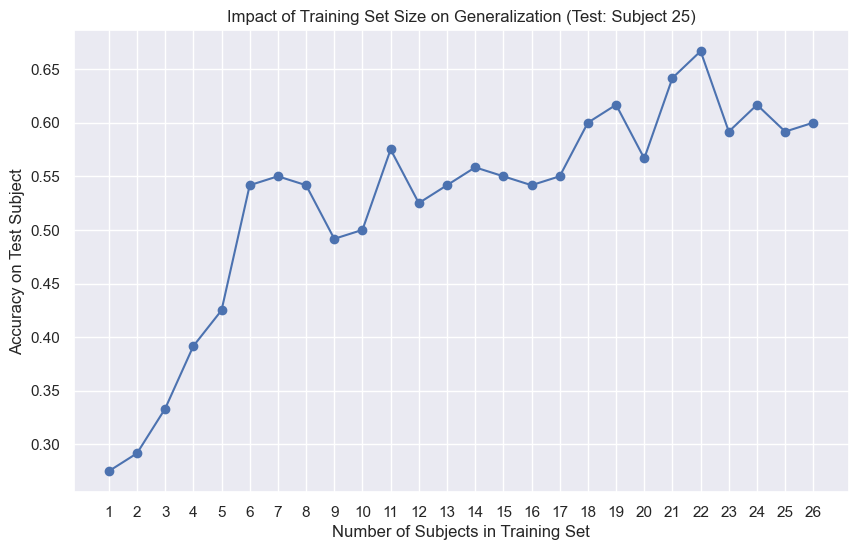

In [53]:
print("\n--- Question 5: Impact of Training Set Size ---")

# Define Fixed Test Subject
test_subject_id = 25
mask_test = (Z_subject == test_subject_id)
X_test_fixed = X_full[mask_test]
y_test_fixed = y_full[mask_test]

print(f"Test Set: Subject {test_subject_id} ({X_test_fixed.shape[0]} samples)")

# Define pool of training subjects (Subjects 1 to 26)
train_pool_ids = np.unique(Z_subject[Z_subject != test_subject_id])
# Sort them to ensure we add them in order (1, then 1+2, etc.)
train_pool_ids.sort()

accuracies_by_size = []
training_sizes = []


rf_params = {
    'n_estimators': 150,     
    'max_depth': 10,         
    "min_samples_split": 8,  # Minimum number of samples required to split an internal node
    "max_features": 'log2',
    'min_samples_leaf': 1,
    'n_jobs': -1,
    'random_state': 42
}

# The Loop: Accumulate subjects
current_train_mask = np.zeros(len(Z_subject), dtype=bool)

for i, subject_to_add in enumerate(train_pool_ids):
    # This adds the new subject to the current training mask
    # We use logical OR to add the new subject's indices to the existing mask
    mask_new_subject = (Z_subject == subject_to_add)
    current_train_mask = current_train_mask | mask_new_subject
    
    # Extract current training data
    X_train_current = X_full[current_train_mask]
    y_train_current = y_full[current_train_mask]

    
    # Train Model
    clf = RandomForestClassifier(**rf_params)
    clf.fit(X_train_current, y_train_current)
    
    # Evaluate
    acc = clf.score(X_test_fixed, y_test_fixed)
    accuracies_by_size.append(acc)
    training_sizes.append(i + 1)
    
    print(f"Training with {i+1} subject(s) (Added S{subject_to_add}) -> Test Acc: {acc:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, accuracies_by_size, marker='o', linestyle='-', color='b')
plt.title(f'Impact of Training Set Size on Generalization (Test: Subject {test_subject_id})')
plt.xlabel('Number of Subjects in Training Set')
plt.ylabel('Accuracy on Test Subject')
plt.grid(True)
plt.xticks(training_sizes) 
plt.show()